In [4]:
print("Homework 4")
print("Tariel Hakobyan")

Homework 4
Tariel Hakobyan


In [5]:
# -- Part 1: Trend Analysis -- #
# Setup

import pandas as pd
import matplotlib.pyplot as plt

bundesliga_df = pd.read_csv("bundesliga.csv")

print(bundesliga_df.head())

   SEASON        LEAGUE        DATE       HOMETEAM        AWAYTEAM FTSC  FTHG  \
0    1994  Bundesliga 1  1993-08-07  Bayern Munich        Freiburg  3-1     3   
1    1994  Bundesliga 1  1993-08-07       Dortmund       Karlsruhe  2-1     2   
2    1994  Bundesliga 1  1993-08-07       Duisburg      Leverkusen  2-2     2   
3    1994  Bundesliga 1  1993-08-07        FC Koln  Kaiserslautern  0-2     0   
4    1994  Bundesliga 1  1993-08-07        Hamburg        Nurnberg  5-2     5   

   FTAG  FTTG  
0     1     4  
1     1     3  
2     2     4  
3     2     2  
4     2     7  


Season Stats:
   SEASON  total_goals  num_matches  avg_goals_per_match
0    1994          895          306             2.924837
1    1995          918          306             3.000000
2    1996          831          306             2.715686
3    1997          911          306             2.977124
4    1998          883          306             2.885621


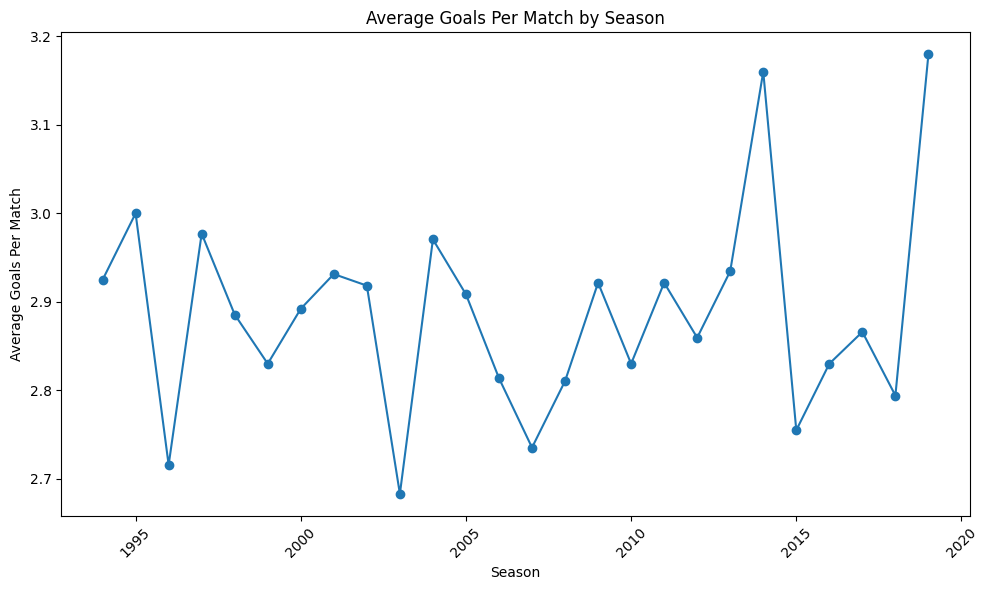

In [6]:
# 1. Analyse trend of goals per season. For example total goals per match, average goals per match.

bundesliga_df['FTTG'] = pd.to_numeric(bundesliga_df['FTTG'], errors='coerce')

season_stats = bundesliga_df.groupby("SEASON").agg(
    total_goals=('FTTG', 'sum'),
    num_matches=('FTTG', 'count')
).reset_index()
season_stats['avg_goals_per_match'] = season_stats['total_goals'] / season_stats['num_matches']

print("Season Stats:")
print(season_stats.head())

plt.figure(figsize=(10, 6))
plt.plot(season_stats['SEASON'], season_stats['avg_goals_per_match'], marker='o')
plt.title("Average Goals Per Match by Season")
plt.xlabel("Season")
plt.ylabel("Average Goals Per Match")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

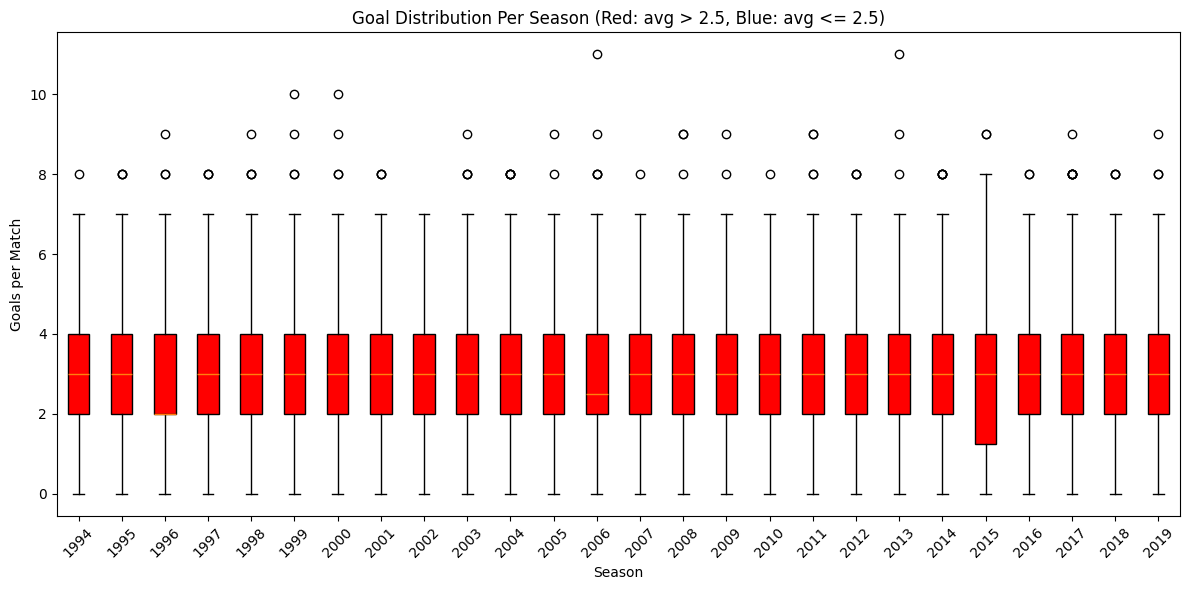

In [7]:
# 2. Goal Distribution Per Season. Use appropriate type of graphs for goals per match, year-wise. Colorcode by whether average is above or below 2.5 (over/under bet threshold).

seasons_sorted = sorted(bundesliga_df['SEASON'].unique())
goals_data = [bundesliga_df[bundesliga_df['SEASON'] == s]['FTTG'].dropna() for s in seasons_sorted]
avg_per_season = [d.mean() for d in goals_data]

fig, ax = plt.subplots(figsize=(12, 6))
boxplot_dict = ax.boxplot(goals_data, patch_artist=True, tick_labels=seasons_sorted)

for box, avg_val in zip(boxplot_dict['boxes'], avg_per_season):
    if avg_val > 2.5:
        box.set_facecolor('red')
    else:
        box.set_facecolor('blue')

ax.set_title("Goal Distribution Per Season")
ax.set_xlabel("Season")
ax.set_ylabel("Goals per Match")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

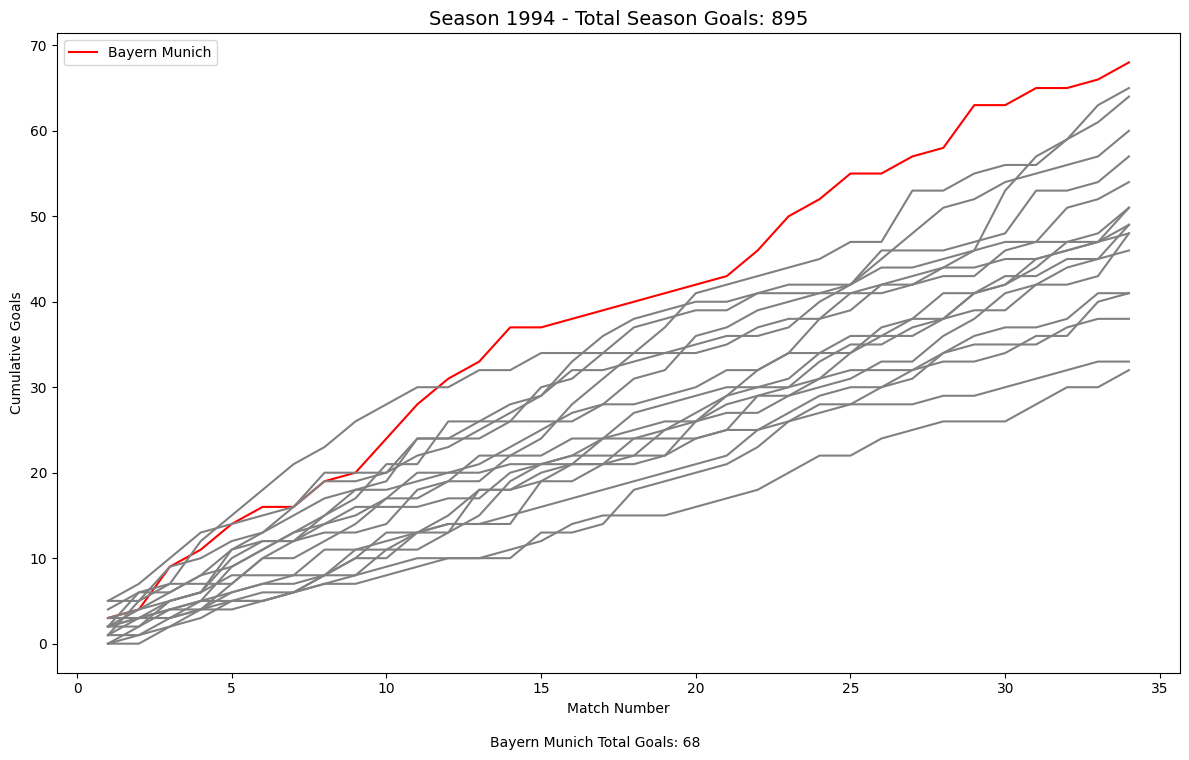

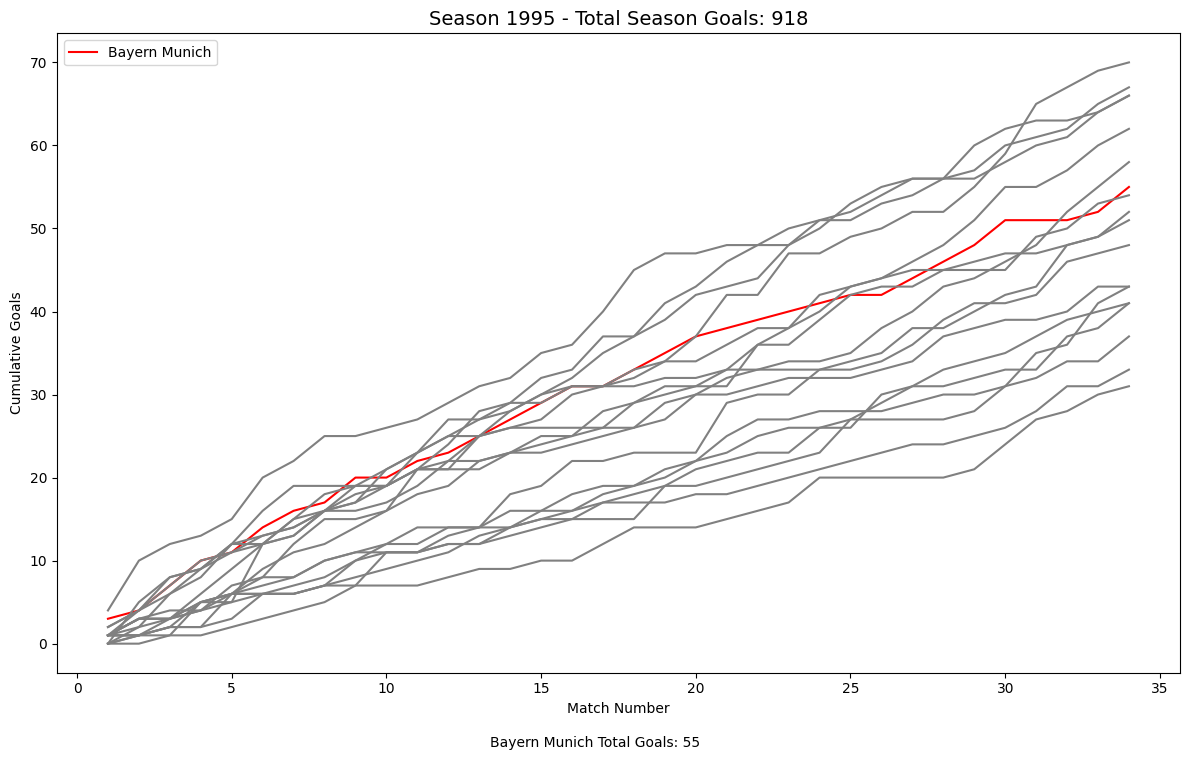

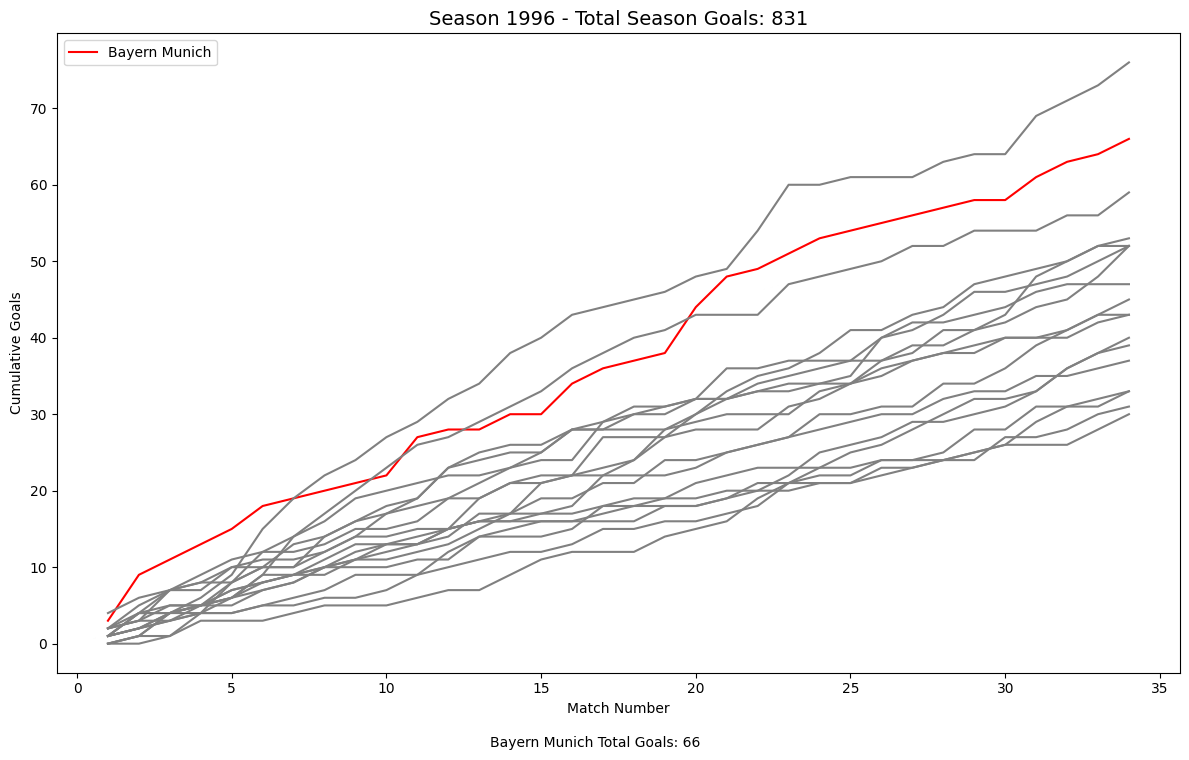

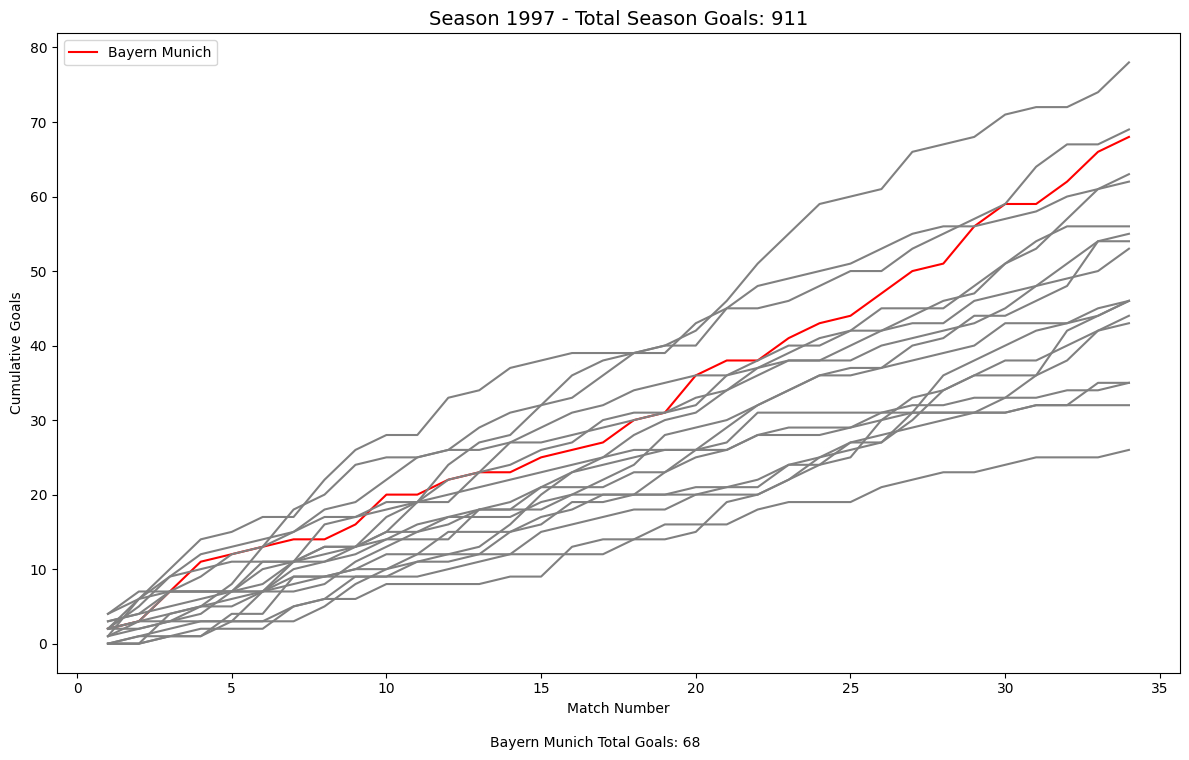

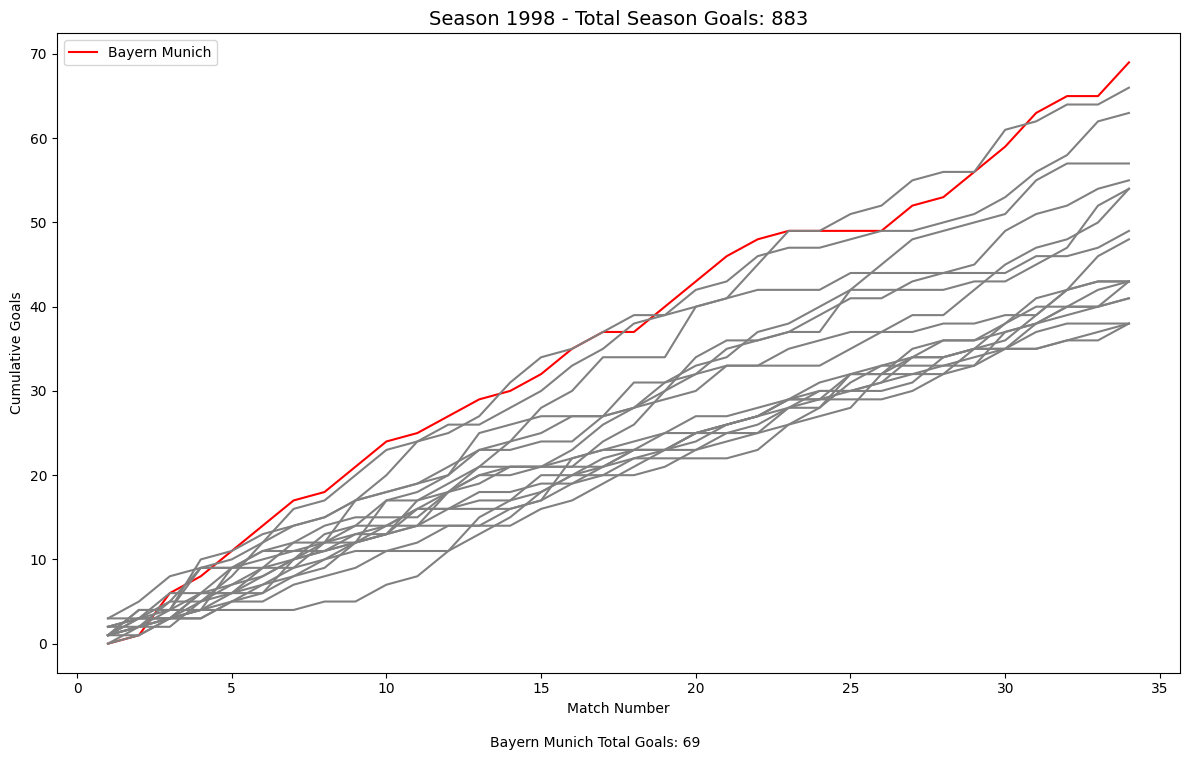

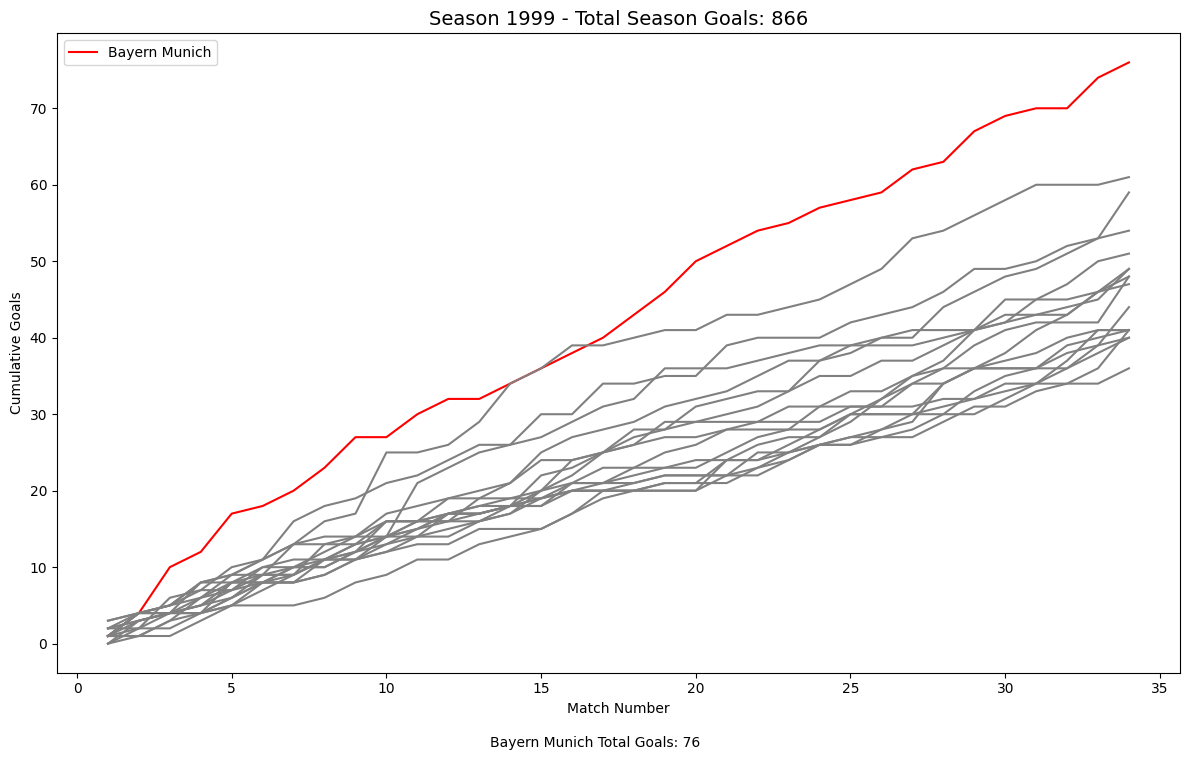

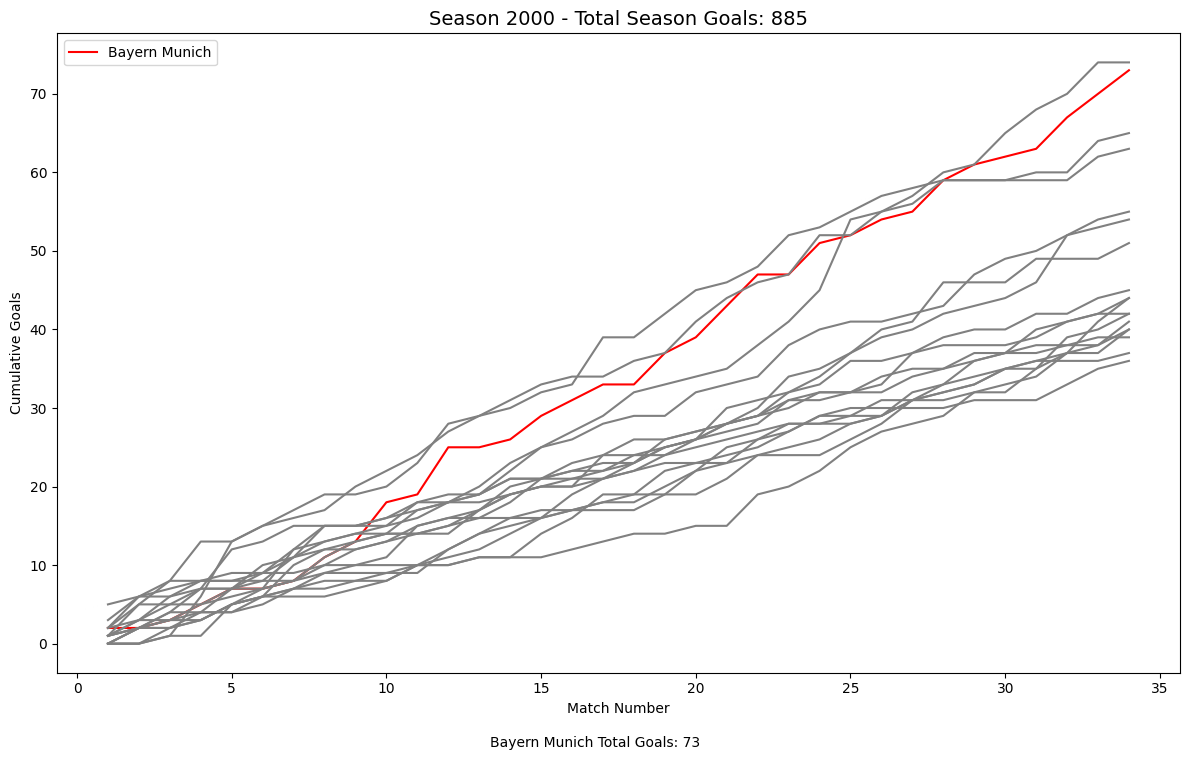

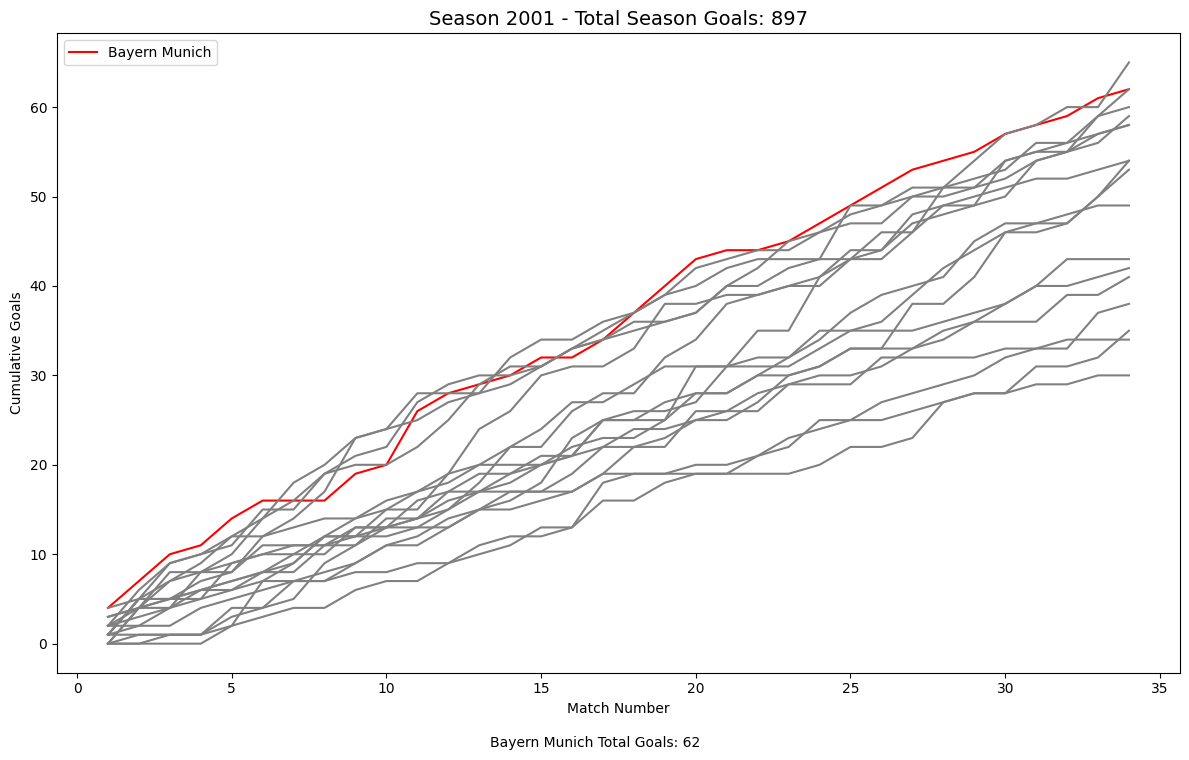

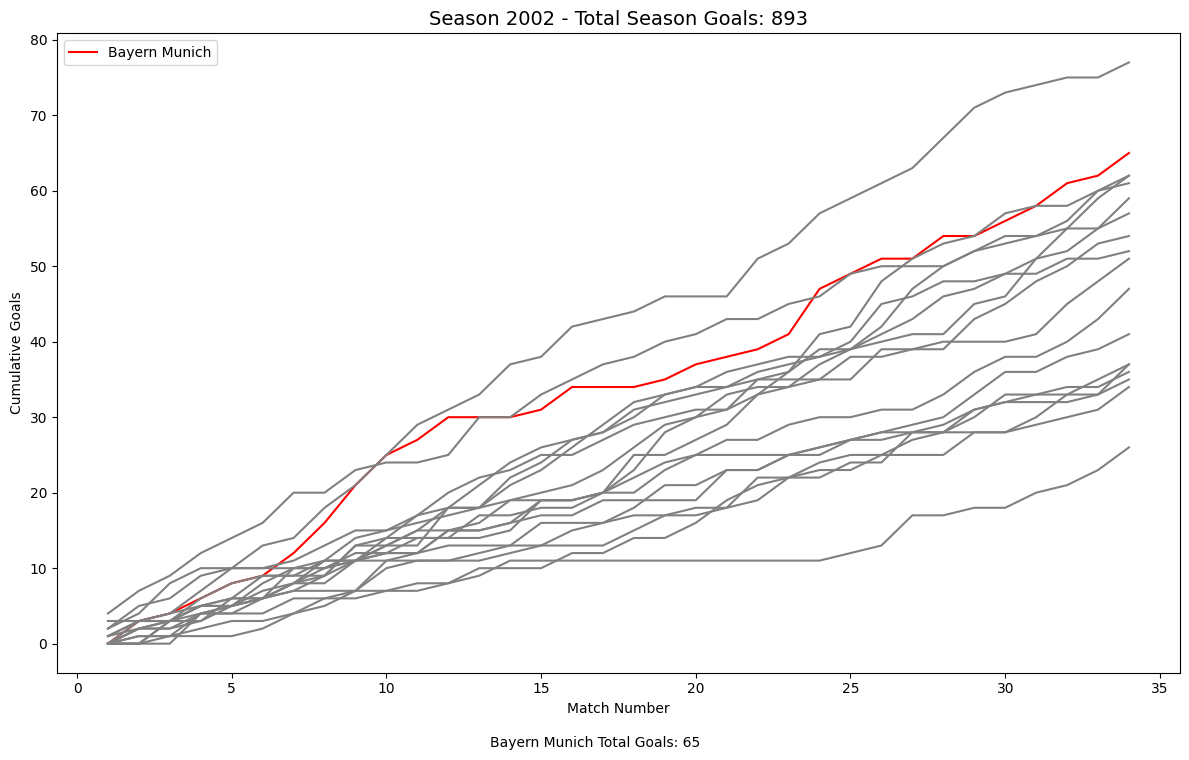

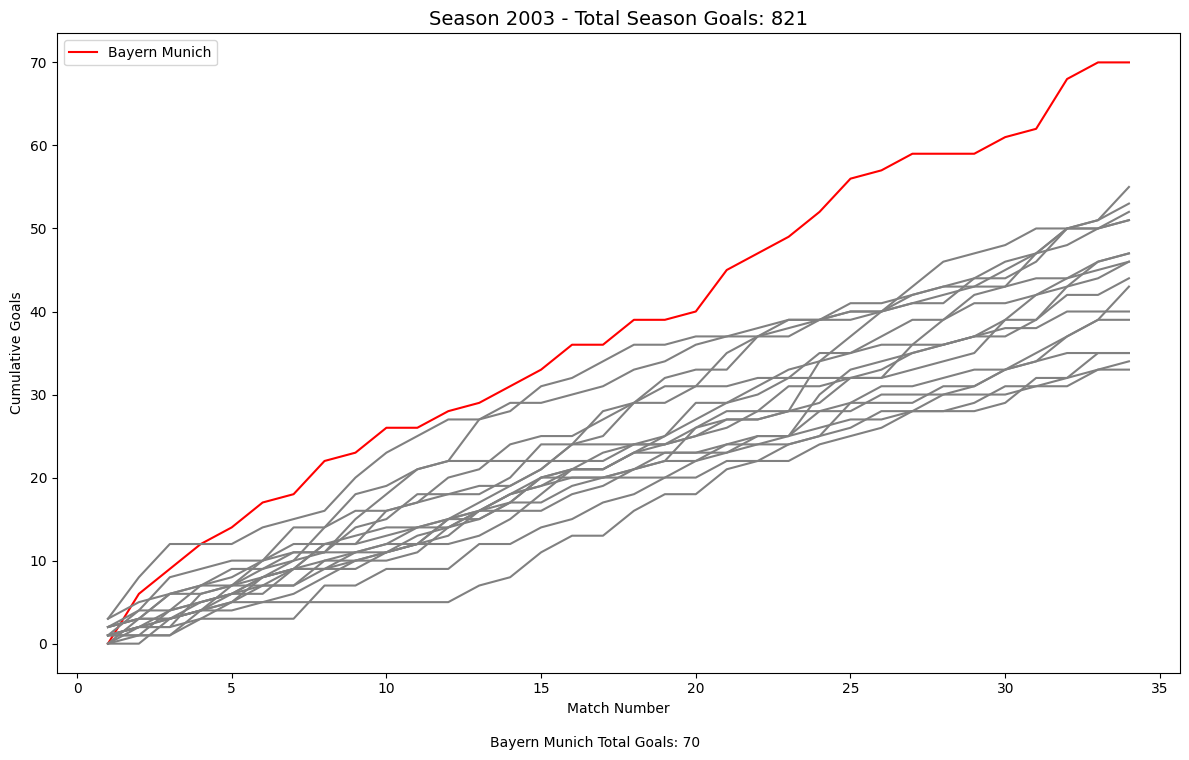

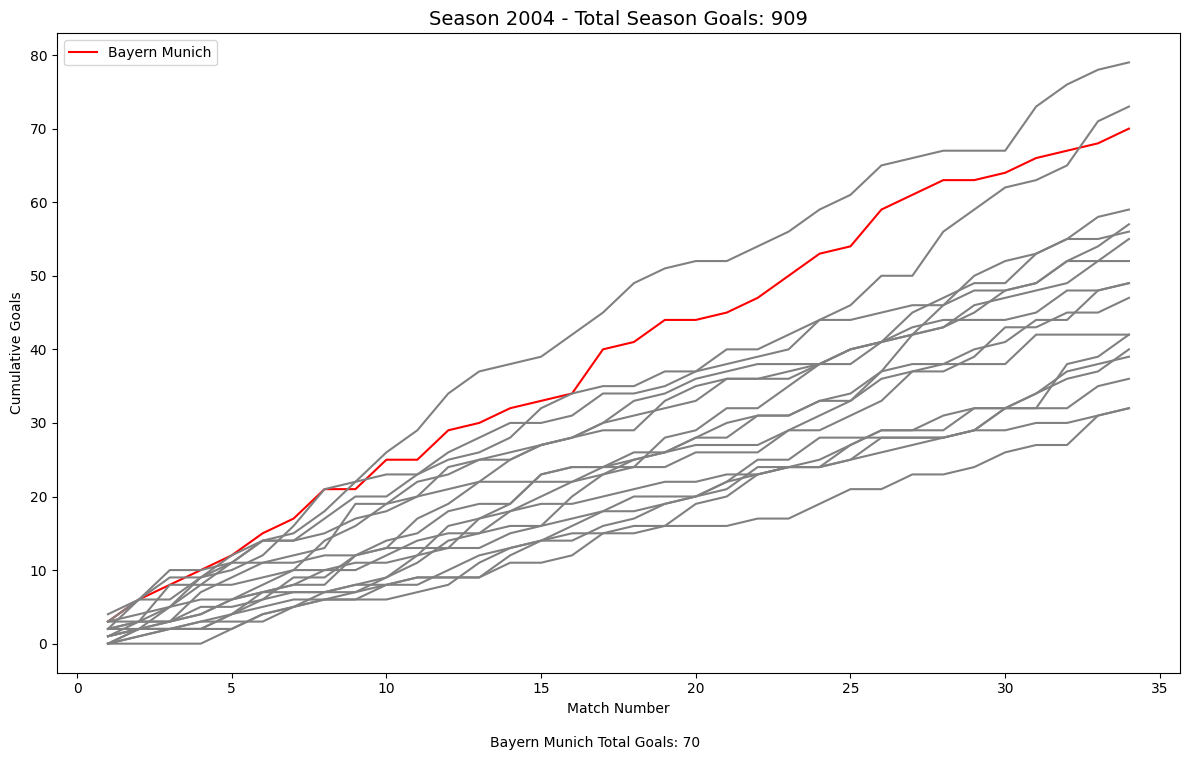

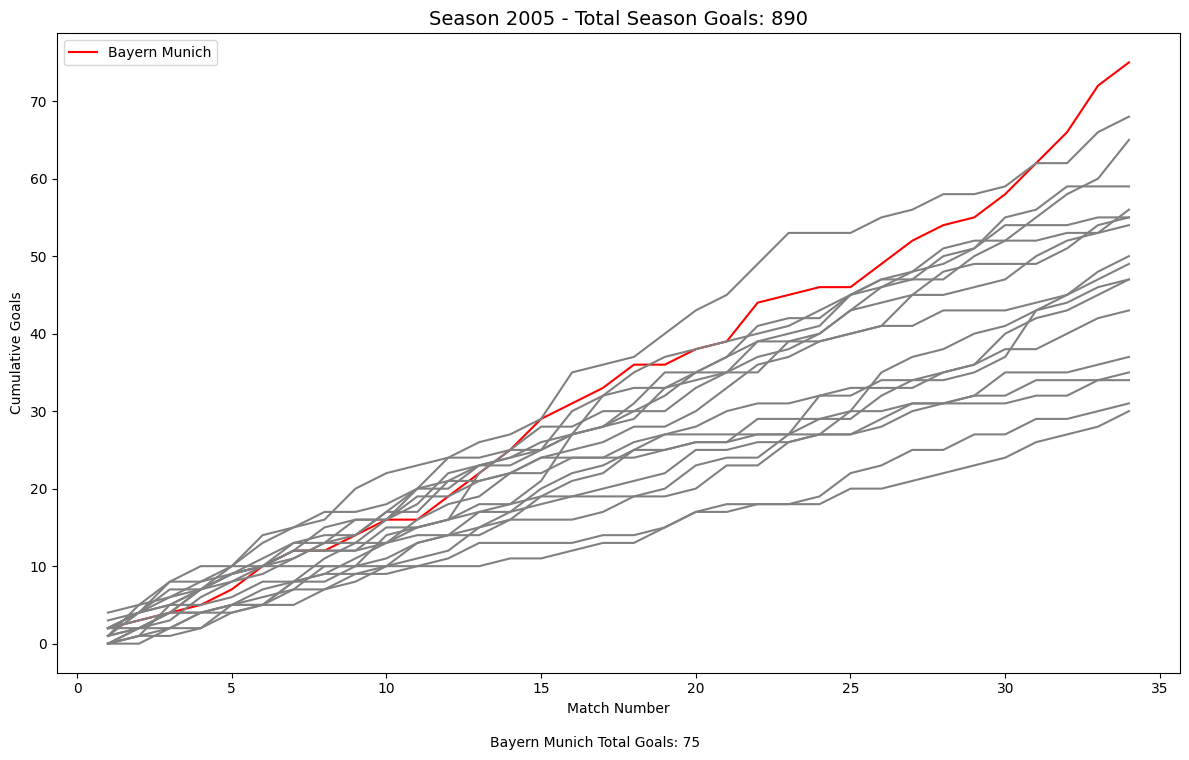

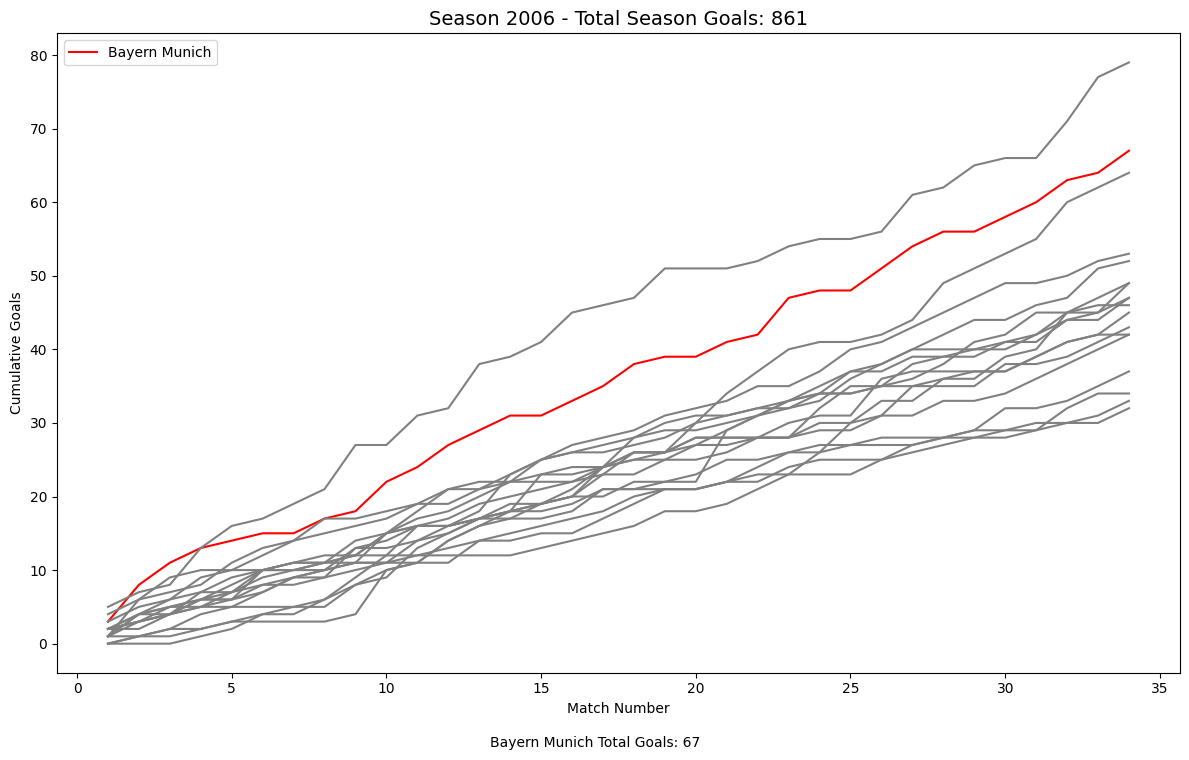

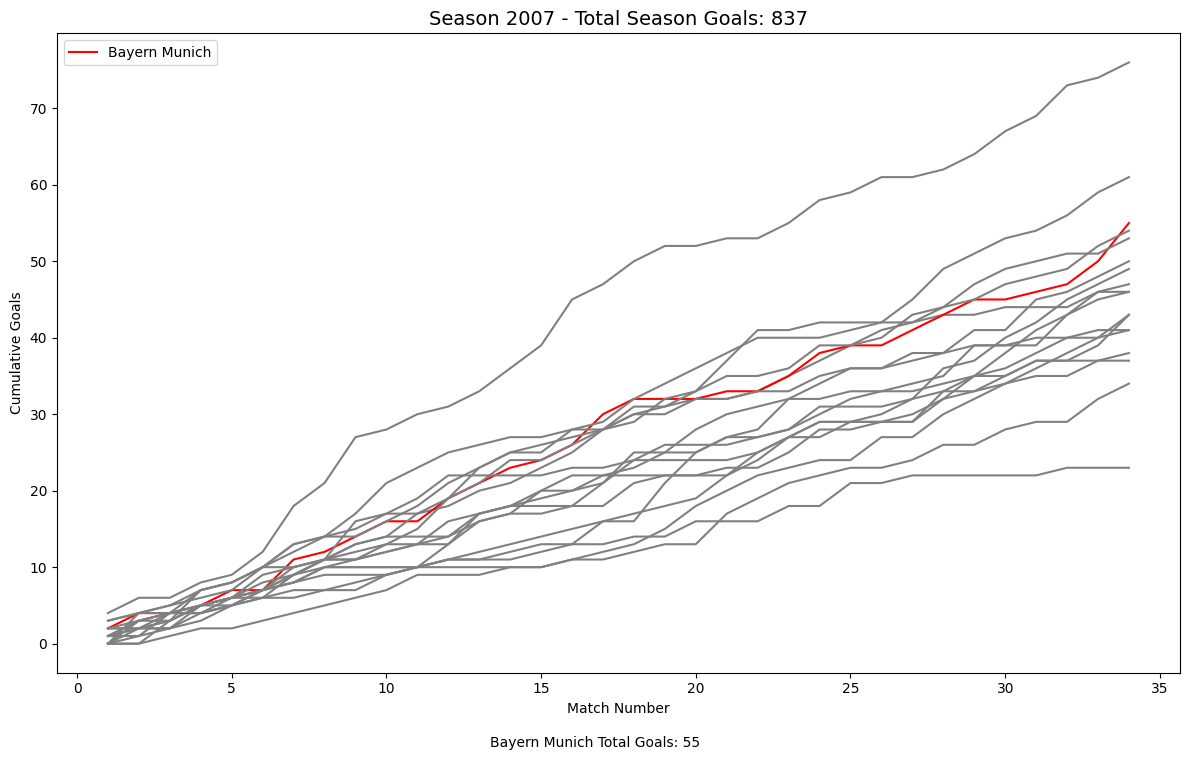

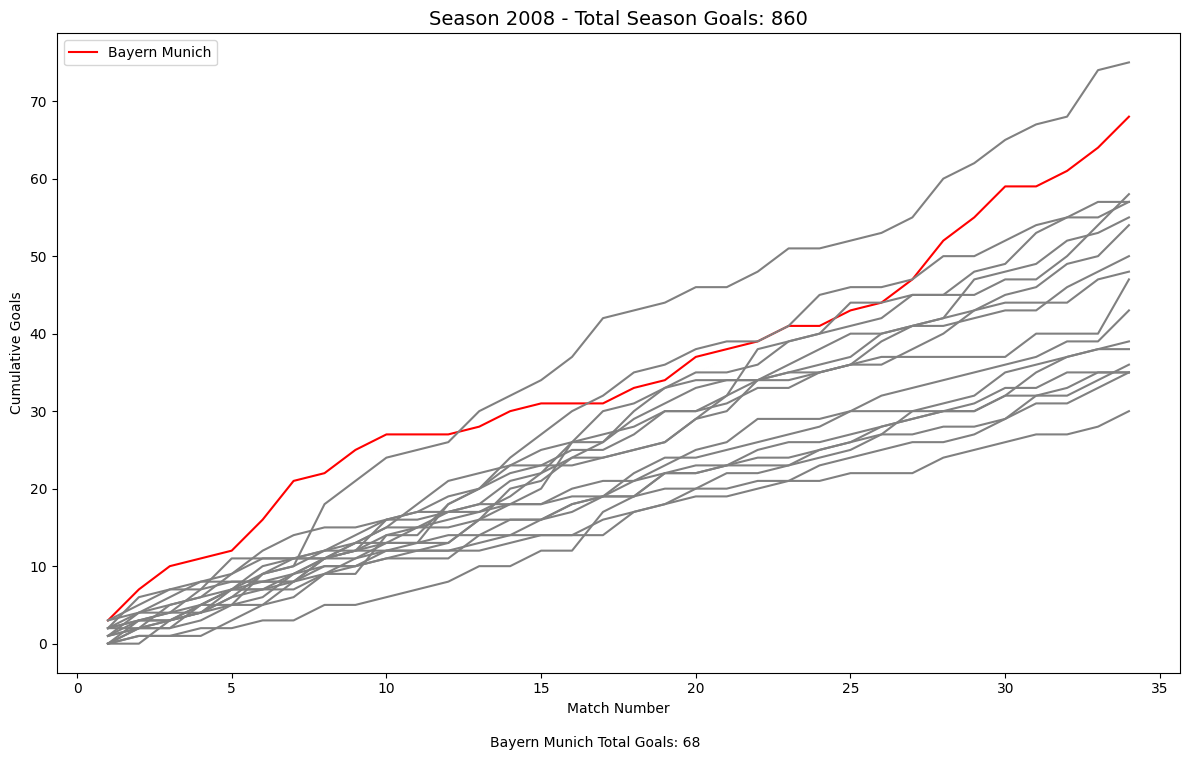

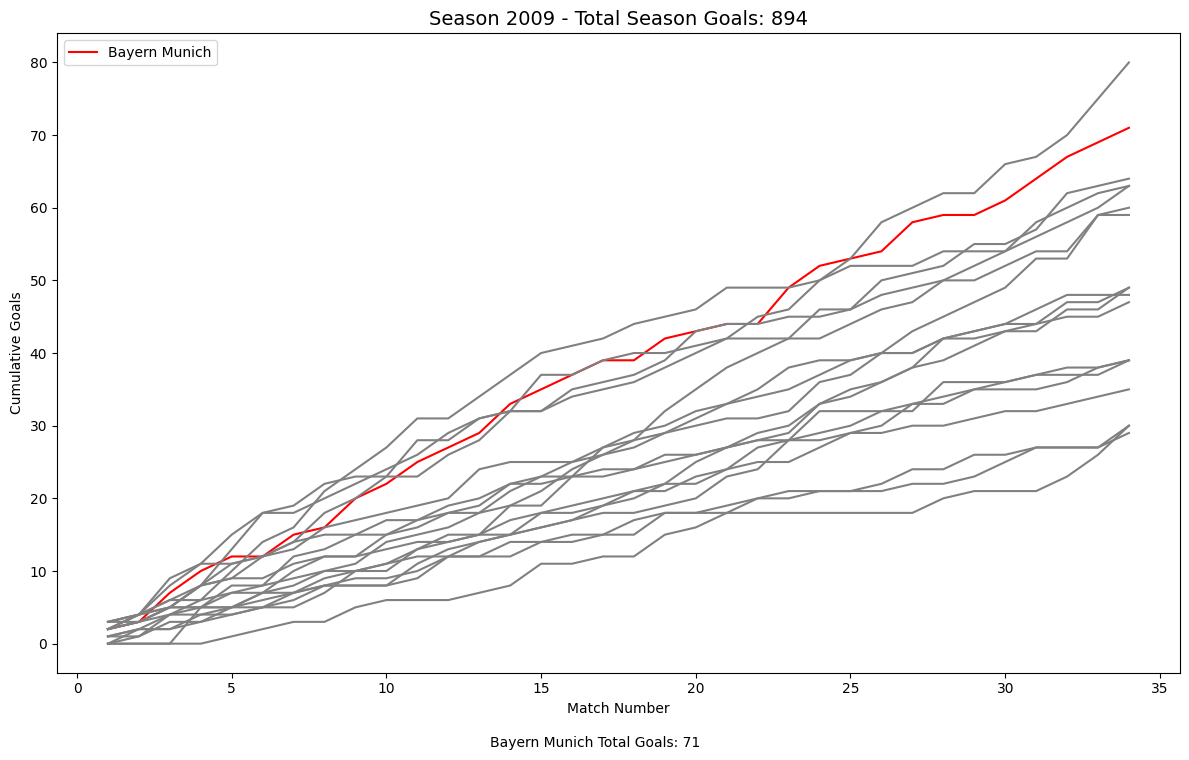

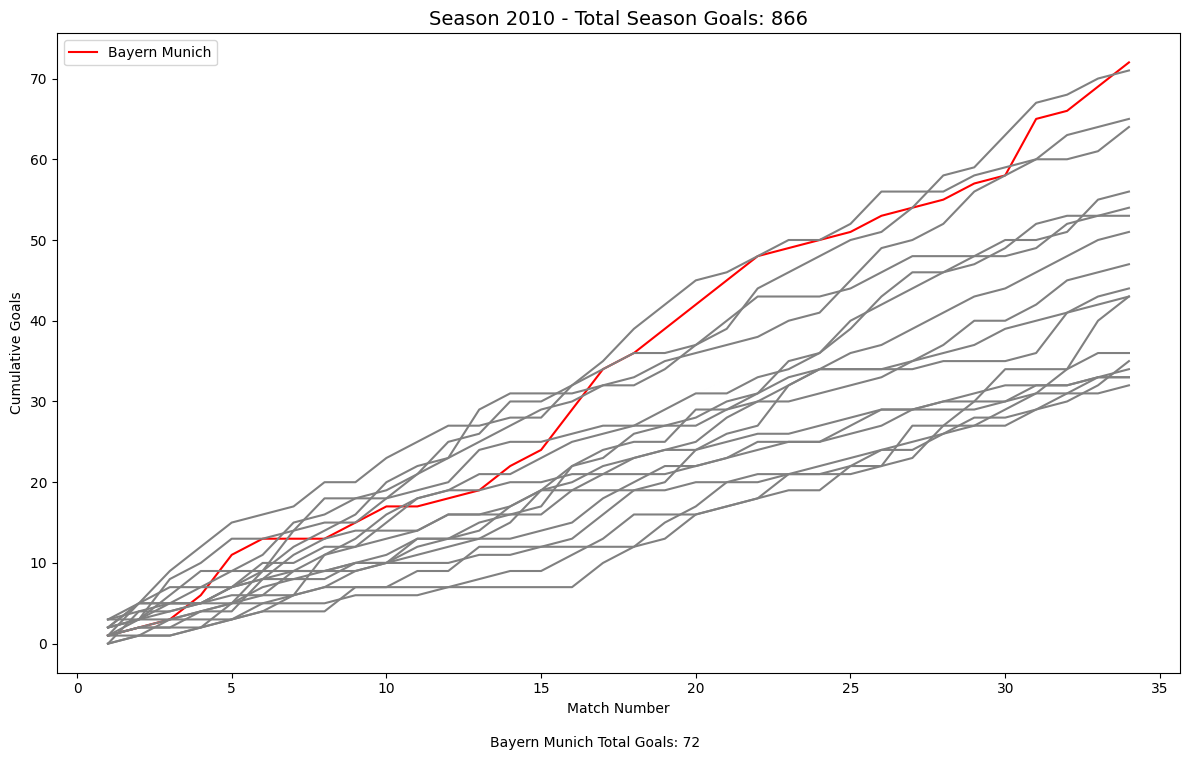

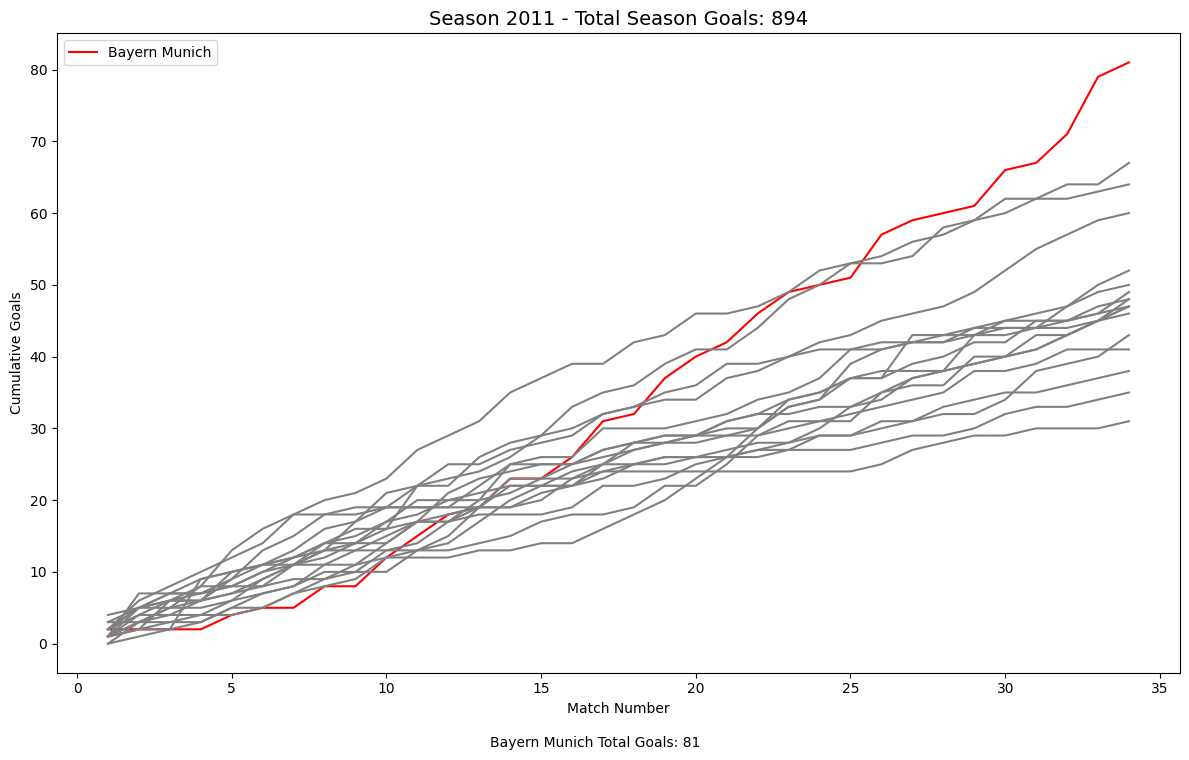

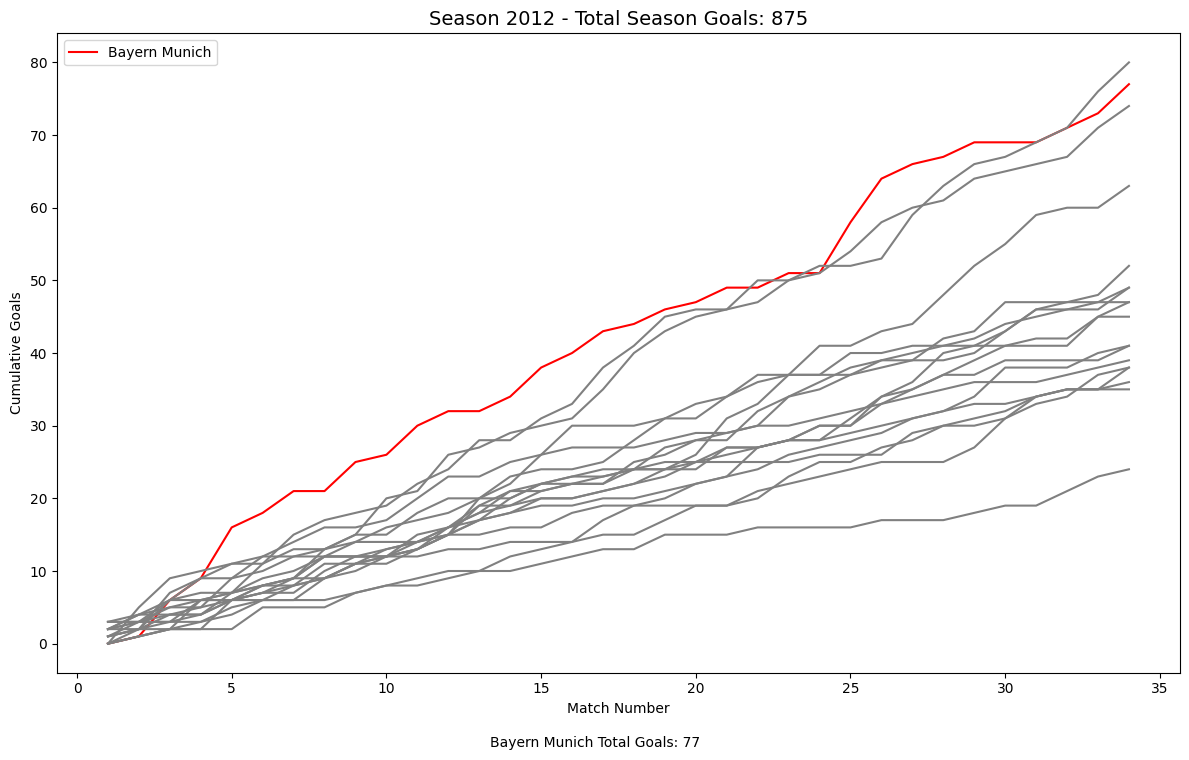

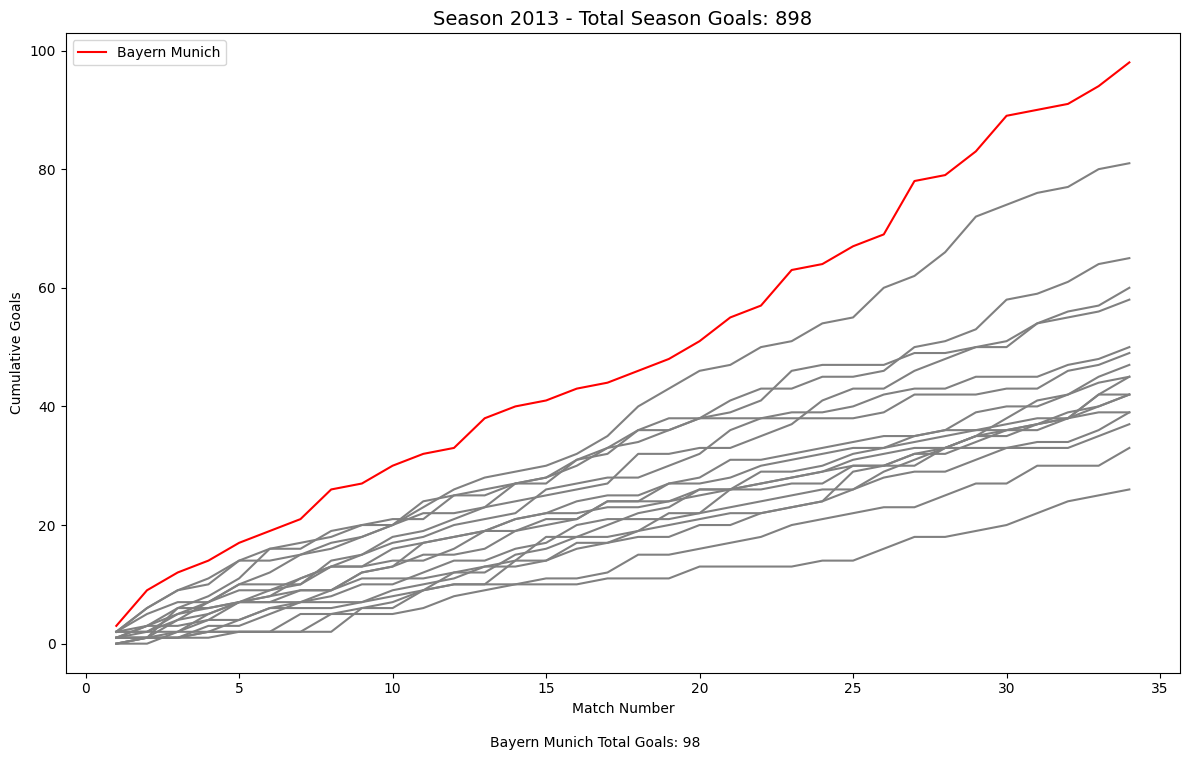

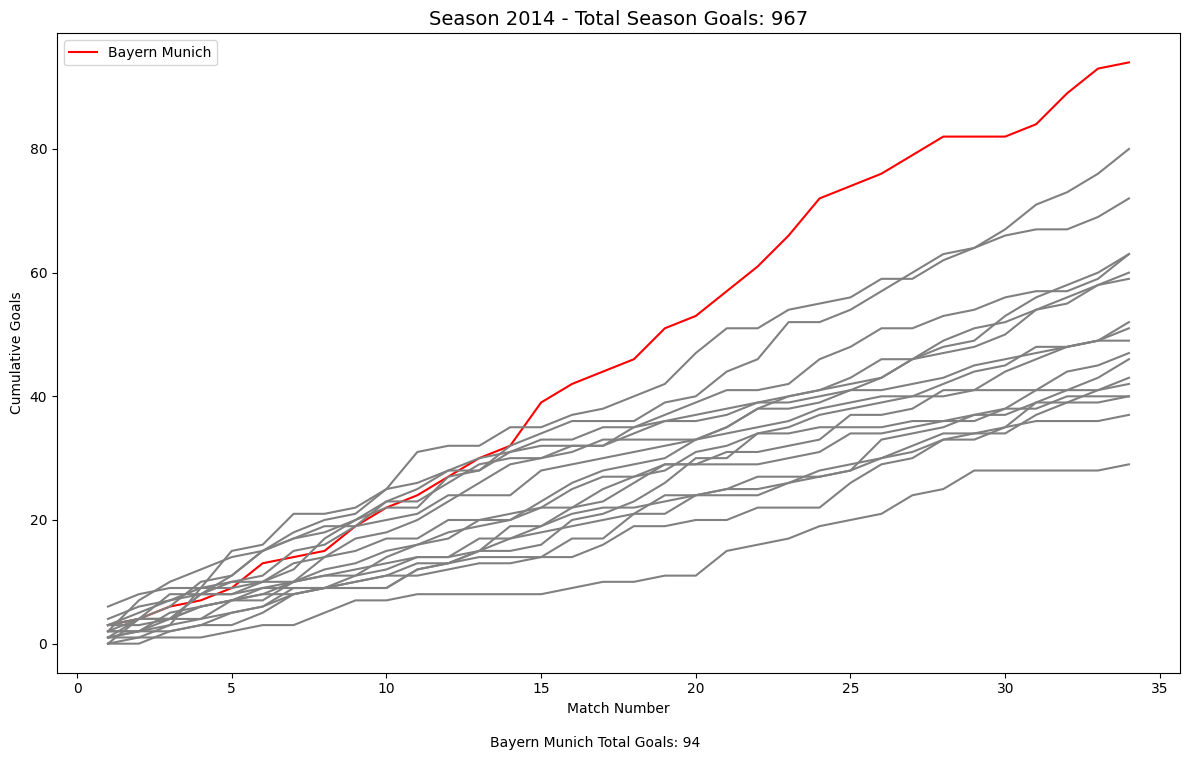

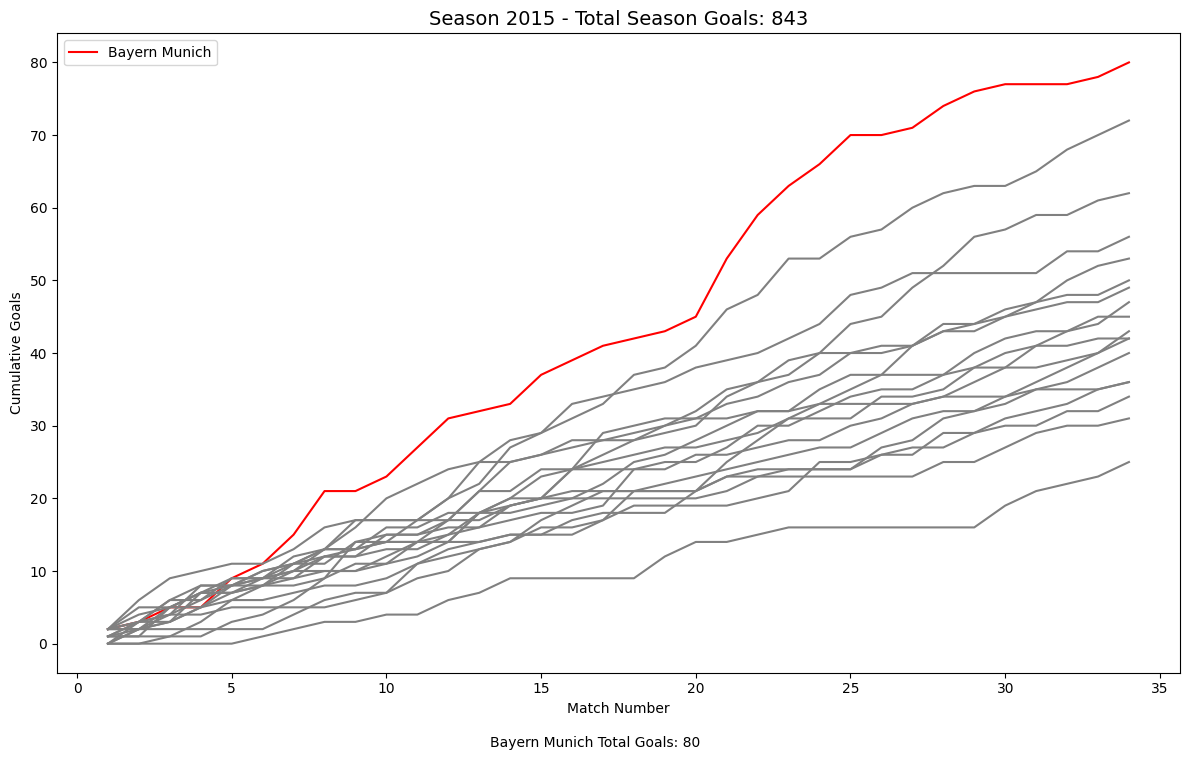

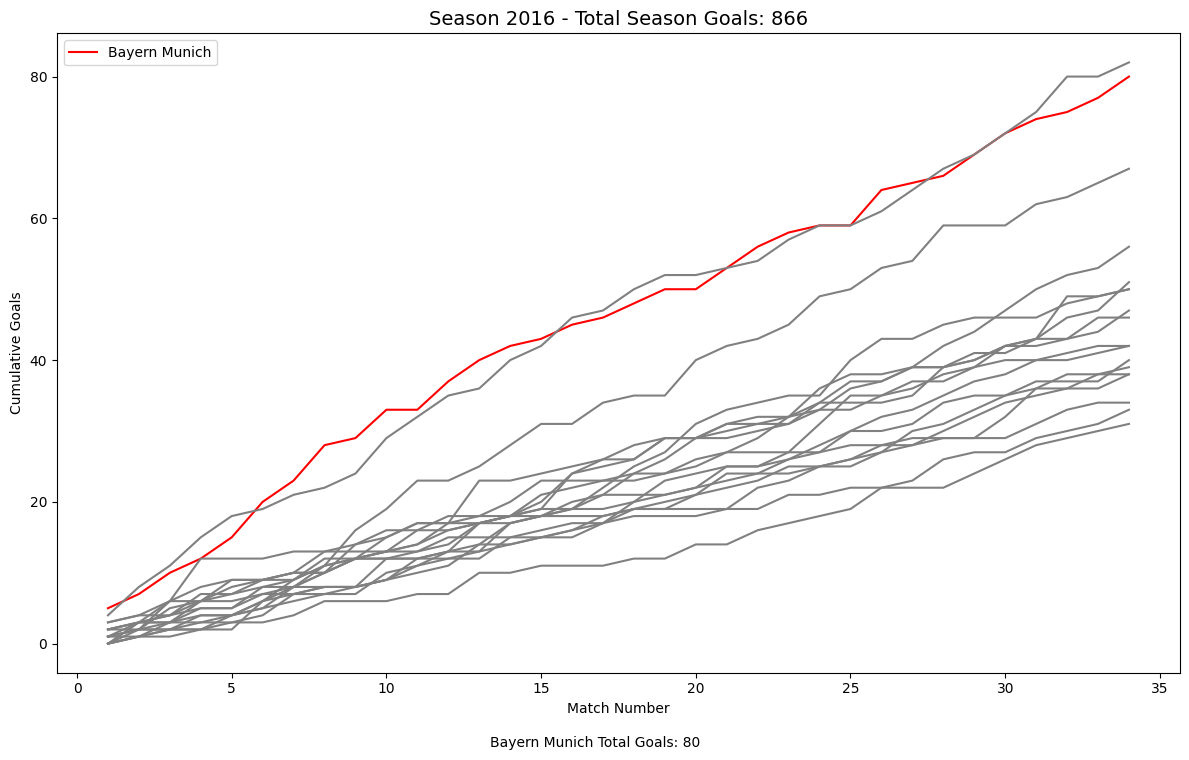

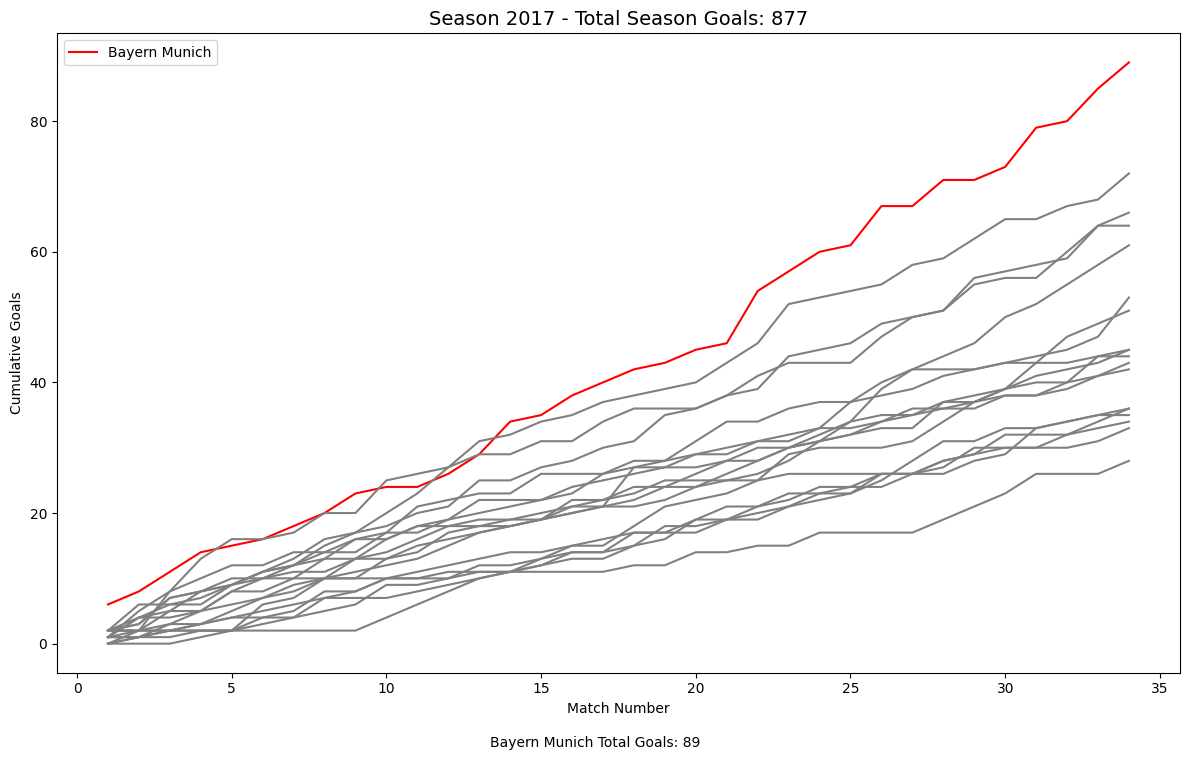

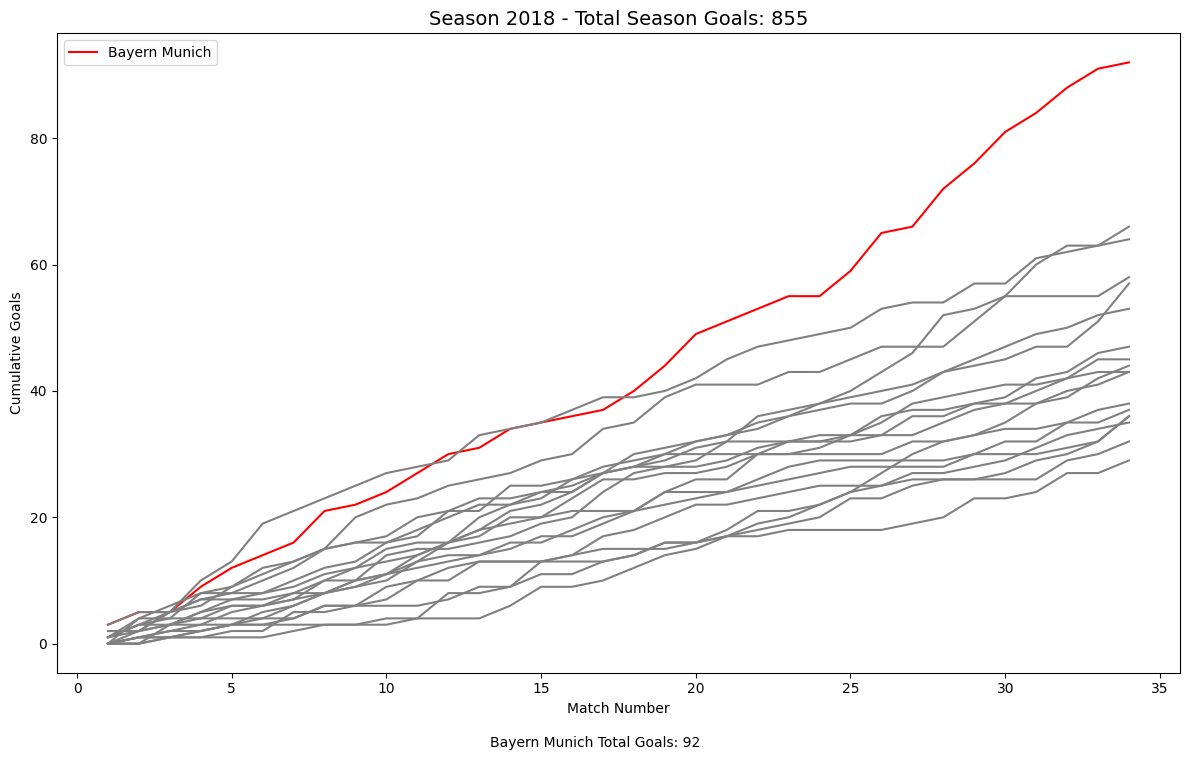

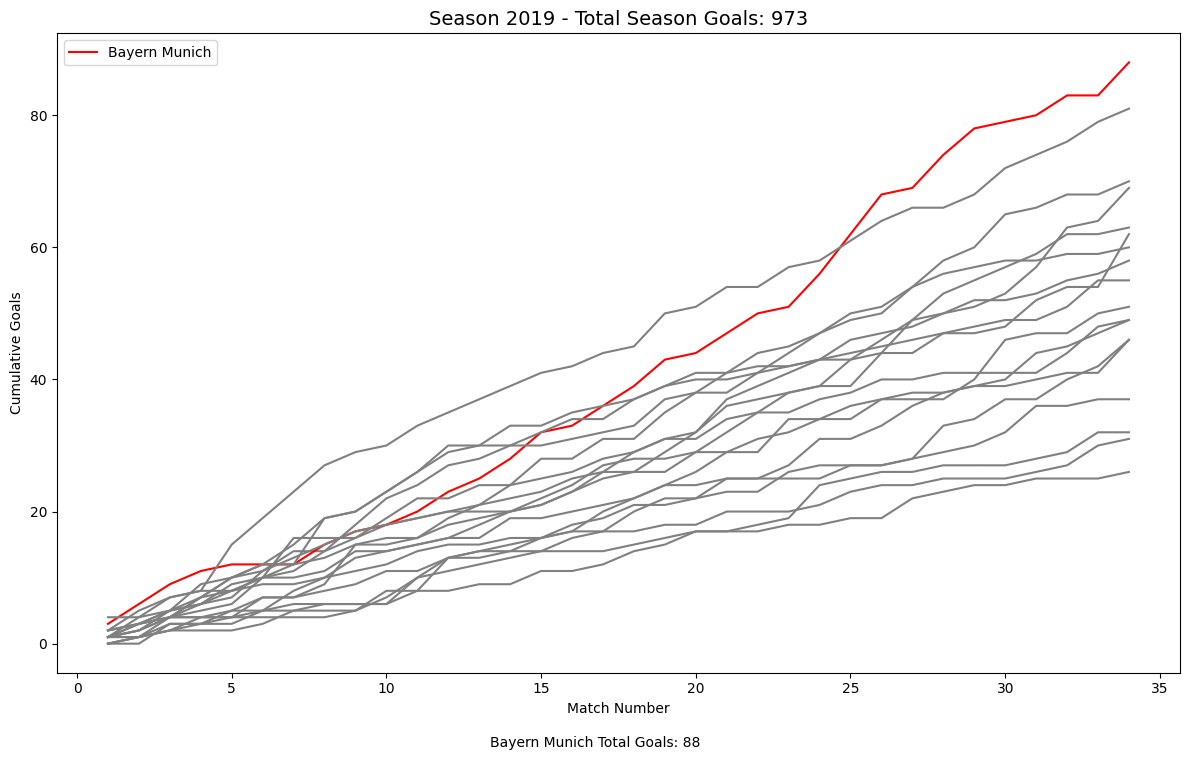

In [8]:
# 3. Create line charts for each season. Visualize trend of goals for each team that played in that season.
# highlight only Bayern Munchen with red color. Rest should be gray. Add appropriate title that will
# contain information about season and total scored goals. Add footnote mentioning total number of
# goals scored by Bayern Munchen for that season. Save all graphs in pdf

bundesliga_df['DATE'] = pd.to_datetime(bundesliga_df['DATE'], errors='coerce')

unique_seasons = sorted(bundesliga_df['SEASON'].unique())

for curr_season in unique_seasons:
    season_subset = bundesliga_df[bundesliga_df['SEASON'] == curr_season].copy()
    season_total_goals = season_subset['FTTG'].sum()

    teams_home = season_subset['HOMETEAM'].unique().tolist()
    teams_away = season_subset['AWAYTEAM'].unique().tolist()
    team_list = sorted(list(set(teams_home + teams_away)))

    plt.figure(figsize=(12, 8))

    for club in team_list:
        club_home = season_subset[season_subset['HOMETEAM'] == club][['DATE', 'FTHG']]
        club_home = club_home.rename(columns={'FTHG': 'Goals'})

        club_away = season_subset[season_subset['AWAYTEAM'] == club][['DATE', 'FTAG']]
        club_away = club_away.rename(columns={'FTAG': 'Goals'})

        club_matches = pd.concat([club_home, club_away]).sort_values(by='DATE')
        club_matches['CumulativeGoals'] = club_matches['Goals'].cumsum()
        club_matches = club_matches.reset_index(drop=True)

        line_color = 'red' if club == "Bayern Munich" else 'gray'

        plt.plot(club_matches.index + 1, club_matches['CumulativeGoals'],
                 label=club if club == "Bayern Munich" else None,
                 color=line_color)

    bayern_home_goals = season_subset[season_subset['HOMETEAM'] == "Bayern Munich"]['FTHG'].sum()
    bayern_away_goals = season_subset[season_subset['AWAYTEAM'] == "Bayern Munich"]['FTAG'].sum()
    bayern_total = bayern_home_goals + bayern_away_goals

    plt.title(f"Season {curr_season} - Total Season Goals: {season_total_goals}", fontsize=14)
    plt.xlabel("Match Number")
    plt.ylabel("Cumulative Goals")
    if "Bayern Munich" in team_list:
        plt.legend(loc='upper left')

    # Add a footnote with Bayern Munich's total goals.
    plt.figtext(0.5, 0.01, f"Bayern Munich Total Goals: {bayern_total}", ha="center", fontsize=10, wrap=True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

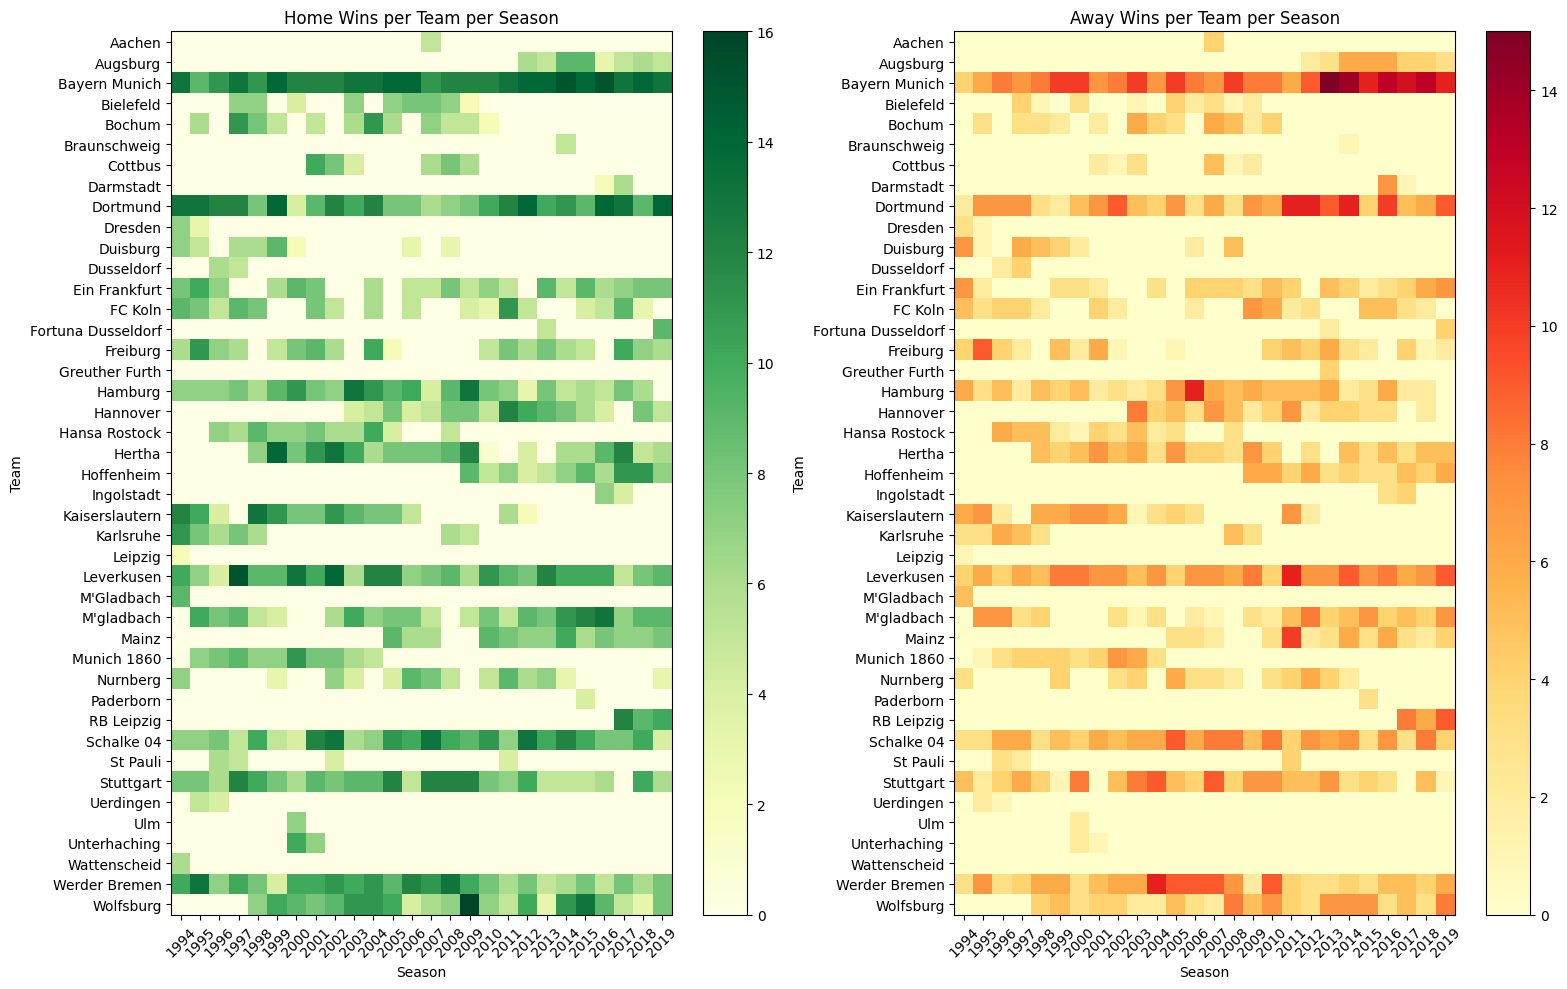

In [9]:
import numpy as np

# -- Part 2: Home Advantage Deconstructed  -- #
# 1. Create Heatmap of Home vs. Away Wins per Team per Season

# FTR is missing from the csv, so let's create it manually
bundesliga_df['FTHG'] = pd.to_numeric(bundesliga_df['FTHG'], errors='coerce')
bundesliga_df['FTAG'] = pd.to_numeric(bundesliga_df['FTAG'], errors='coerce')

conditions = [
    (bundesliga_df['FTHG'] > bundesliga_df['FTAG']),
    (bundesliga_df['FTHG'] == bundesliga_df['FTAG']),
    (bundesliga_df['FTHG'] < bundesliga_df['FTAG'])
]
choices = ["H", "D", "A"]
bundesliga_df['FTR'] = np.select(conditions, choices, default="-")

home_wins = (
    bundesliga_df[bundesliga_df['FTR'] == 'H']
    .groupby(['SEASON', 'HOMETEAM'])
    .size()
    .reset_index(name='HomeWins')
    .rename(columns={'HOMETEAM': 'TEAM'})
)

away_wins = (
    bundesliga_df[bundesliga_df['FTR'] == 'A']
    .groupby(['SEASON', 'AWAYTEAM'])
    .size()
    .reset_index(name='AwayWins')
    .rename(columns={'AWAYTEAM': 'TEAM'})
)

wins_combined = pd.merge(home_wins, away_wins, on=['SEASON', 'TEAM'], how='outer').fillna(0)

pivot_home = wins_combined.pivot(index='TEAM', columns='SEASON', values='HomeWins').fillna(0)
pivot_away = wins_combined.pivot(index='TEAM', columns='SEASON', values='AwayWins').fillna(0)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 10))

# Heatmap for Home Wins
cax1 = ax1.imshow(pivot_home, aspect='auto', cmap='YlGn', interpolation='nearest')
ax1.set_title("Home Wins per Team per Season")
ax1.set_xlabel("Season")
ax1.set_ylabel("Team")
ax1.set_xticks(np.arange(len(pivot_home.columns)))
ax1.set_xticklabels(pivot_home.columns, rotation=45)
ax1.set_yticks(np.arange(len(pivot_home.index)))
ax1.set_yticklabels(pivot_home.index)
fig.colorbar(cax1, ax=ax1)

# Heatmap for Away Wins
cax2 = ax2.imshow(pivot_away, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax2.set_title("Away Wins per Team per Season")
ax2.set_xlabel("Season")
ax2.set_ylabel("Team")
ax2.set_xticks(np.arange(len(pivot_away.columns)))
ax2.set_xticklabels(pivot_away.columns, rotation=45)
ax2.set_yticks(np.arange(len(pivot_away.index)))
ax2.set_yticklabels(pivot_away.index)
fig.colorbar(cax2, ax=ax2)

plt.tight_layout()
plt.show()

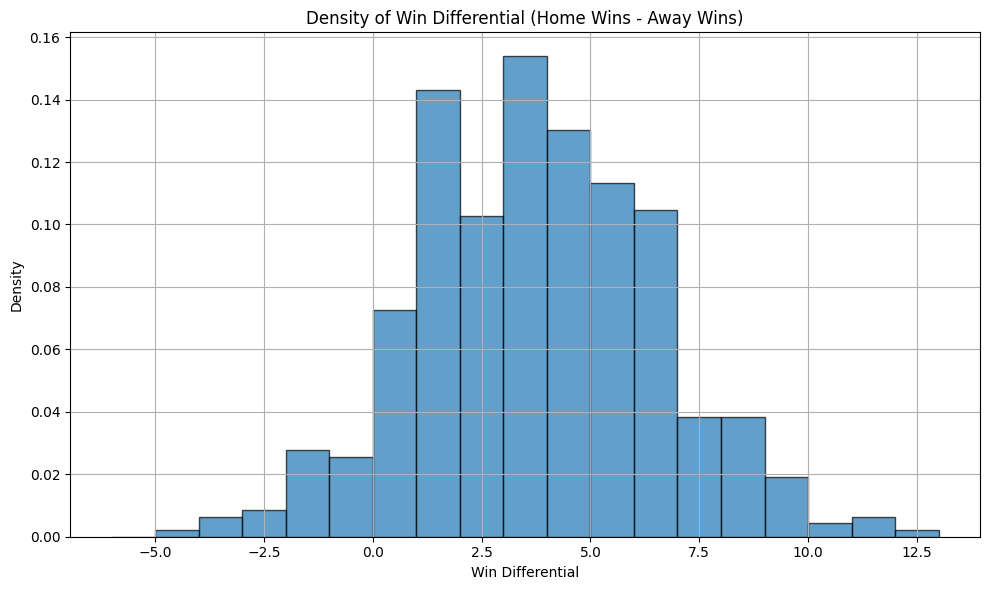

In [10]:
# 2. Point Differential Density: Create visualizations that will show difference per team for home and away
# game wins.

wins_combined['WinDiff'] = wins_combined['HomeWins'] - wins_combined['AwayWins']

plt.figure(figsize=(10, 6))
bins_range = range(int(wins_combined['WinDiff'].min()) - 1, int(wins_combined['WinDiff'].max()) + 2)
plt.hist(wins_combined['WinDiff'], bins=bins_range, density=True, alpha=0.7, edgecolor='black')
plt.title("Density of Win Differential (Home Wins - Away Wins)")
plt.xlabel("Win Differential")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Creating bundesliga2.csv (used later)

# --- Home Stats ---
home_stats = bundesliga_df.groupby(['SEASON', 'HOMETEAM']).agg(
    M_home = ('HOMETEAM', 'count'),
    W_home = ('FTR', lambda x: (x == 'H').sum()),
    D_home = ('FTR', lambda x: (x == 'D').sum()),
    L_home = ('FTR', lambda x: (x == 'A').sum()),
    GF_home = ('FTHG', 'sum'),
    GA_home = ('FTAG', 'sum')
).reset_index().rename(columns={'HOMETEAM': 'TEAM'})

# --- Away Stats ---
away_stats = bundesliga_df.groupby(['SEASON', 'AWAYTEAM']).agg(
    M_away = ('AWAYTEAM', 'count'),
    W_away = ('FTR', lambda x: (x == 'A').sum()),
    D_away = ('FTR', lambda x: (x == 'D').sum()),
    L_away = ('FTR', lambda x: (x == 'H').sum()),
    GF_away = ('FTAG', 'sum'),
    GA_away = ('FTHG', 'sum')
).reset_index().rename(columns={'AWAYTEAM': 'TEAM'})

final_stats = pd.merge(home_stats, away_stats, on=['SEASON', 'TEAM'], how='outer').fillna(0)

# --- Total Stats ---
final_stats['M']      = final_stats['M_home'] + final_stats['M_away']
final_stats['W']      = final_stats['W_home'] + final_stats['W_away']
final_stats['D']      = final_stats['D_home'] + final_stats['D_away']
final_stats['L']      = final_stats['L_home'] + final_stats['L_away']
final_stats['GF']     = final_stats['GF_home'] + final_stats['GF_away']
final_stats['GA']     = final_stats['GA_home'] + final_stats['GA_away']
final_stats['DIFF']   = final_stats['GF'] - final_stats['GA']
final_stats['POINTS'] = final_stats['W'] * 3 + final_stats['D']

# --- Ranking ---
final_stats = final_stats.sort_values(['SEASON', 'POINTS', 'DIFF', 'GF'], ascending=[True, False, False, False])
final_stats['POSITION'] = final_stats.groupby('SEASON').cumcount() + 1

bundesliga2_df = final_stats[['TEAM', 'M', 'W', 'D', 'L', 'GF', 'GA', 'DIFF', 'POINTS', 'POSITION', 'SEASON']].copy()

print("Final Standings:")
print(bundesliga2_df.head())

Final Standings (bundesliga2_df):
              TEAM   M   W   D   L  GF  GA  DIFF  POINTS  POSITION  SEASON
0    Bayern Munich  34  17  10   7  68  37    31      61         1    1994
8   Kaiserslautern  34  18   7   9  64  36    28      61         2    1994
1         Dortmund  34  15   9  10  49  45     4      54         3    1994
4    Ein Frankfurt  34  15   8  11  57  41    16      53         4    1994
11      Leverkusen  34  14  11   9  60  47    13      53         5    1994
9        Karlsruhe  34  14  10  10  46  43     3      52         6    1994
15       Stuttgart  34  13  11  10  51  43     8      50         7    1994
3         Duisburg  34  14   8  12  41  52   -11      50         8    1994
17   Werder Bremen  34  13  10  11  51  44     7      49         9    1994
12      M'Gladbach  34  14   7  13  65  59     6      49        10    1994


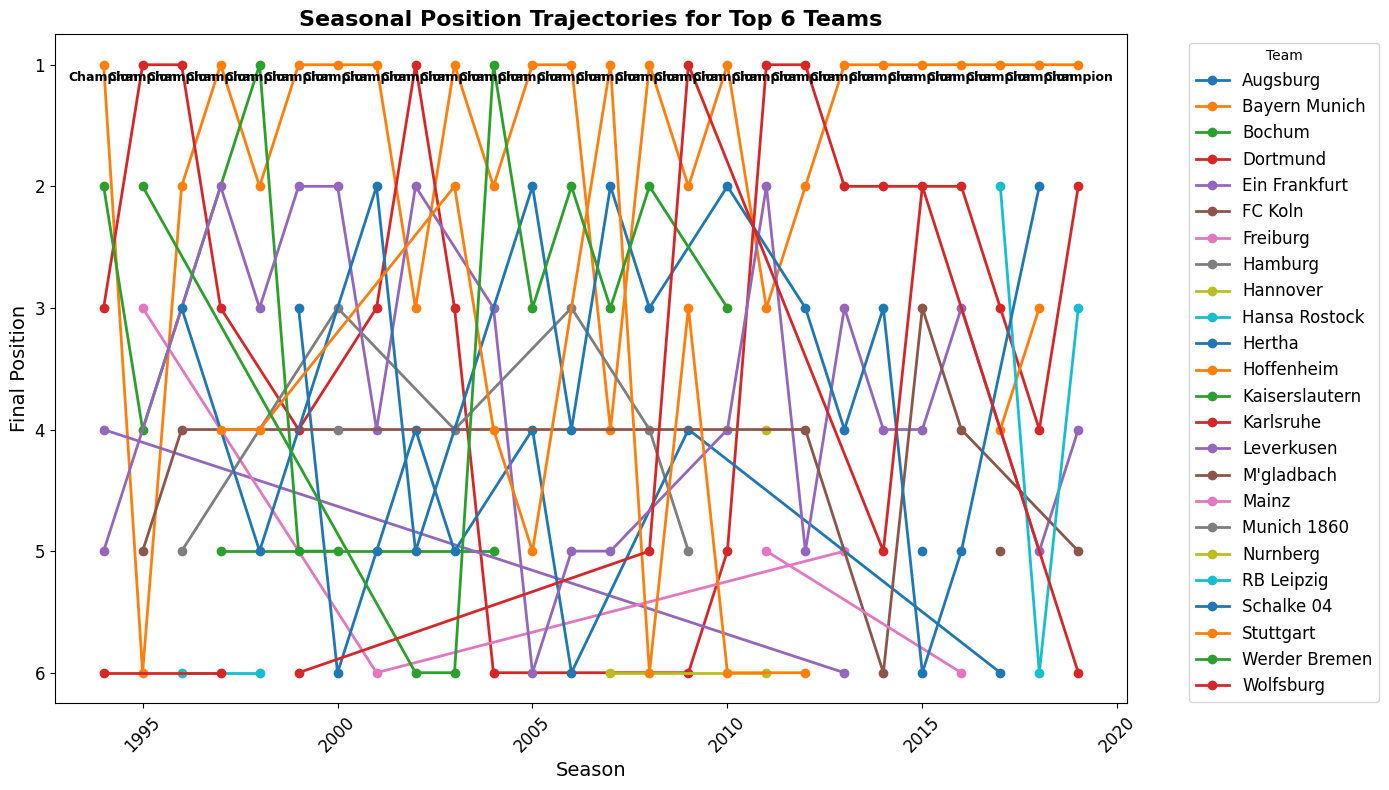

In [12]:
# -- Part 3  -- #
# 1. Team Trajectories and Volatility
# • Seasonal Position Trajectories
# • Line plots showing seasonal ranks for top 6 teams.
# • Annotate title-winning seasons.

top6_df = bundesliga2_df[bundesliga2_df['POSITION'] <= 6]

plt.figure(figsize=(14, 8))
teams_top6 = sorted(top6_df['TEAM'].unique())

for team in teams_top6:
    team_df = top6_df[top6_df['TEAM'] == team].sort_values('SEASON')
    plt.plot(team_df['SEASON'], team_df['POSITION'], marker='o', markersize=6, linewidth=2, label=team)

    champion_df = team_df[team_df['POSITION'] == 1]
    for idx, row in champion_df.iterrows():
        plt.annotate("Champion",
                     (row['SEASON'], row['POSITION']),
                     textcoords="offset points",
                     xytext=(0, -12),
                     ha='center', fontsize=9, fontweight='bold')

plt.gca().invert_yaxis()  # to show 1st position at the top
plt.title("Seasonal Position Trajectories for Top 6 Teams", fontsize=16, fontweight='bold')
plt.xlabel("Season", fontsize=14)
plt.ylabel("Final Position", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Team", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

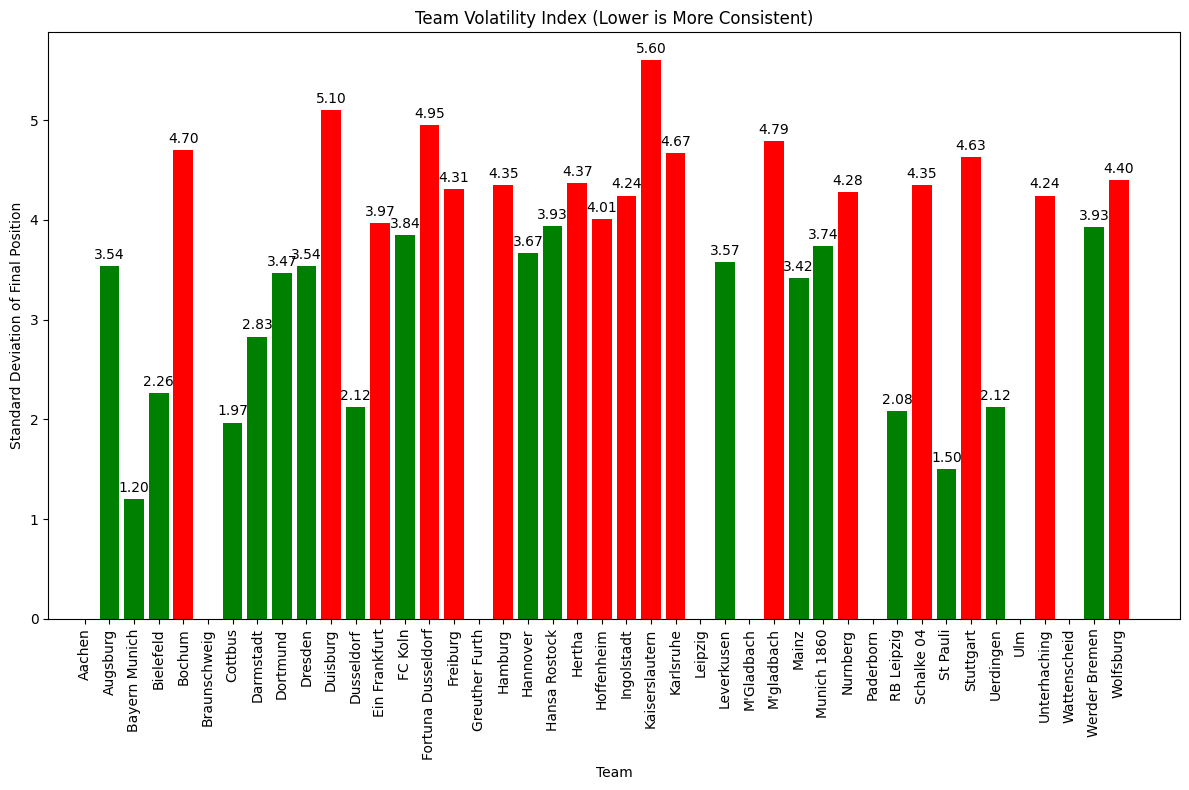

In [13]:
# 2. Volatility Index
# • For each team, calculate standard deviation of final rank over all seasons.
# • Use a bar chart with conditional coloring (e.g., red = unstable, green = consistent).
# • Add text labels above each bar with exact values.

volatility_df = bundesliga2_df.groupby('TEAM')['POSITION'].std().reset_index().rename(columns={'POSITION': 'Volatility'})

median_vol = volatility_df['Volatility'].median()
volatility_df['Color'] = np.where(volatility_df['Volatility'] > median_vol, 'red', 'green')

plt.figure(figsize=(12, 8))
bars = plt.bar(volatility_df['TEAM'], volatility_df['Volatility'], color=volatility_df['Color'])
plt.xlabel("Team")
plt.ylabel("Standard Deviation of Final Position")
plt.title("Team Volatility Index (Lower is More Consistent)")
plt.xticks(rotation=90)

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

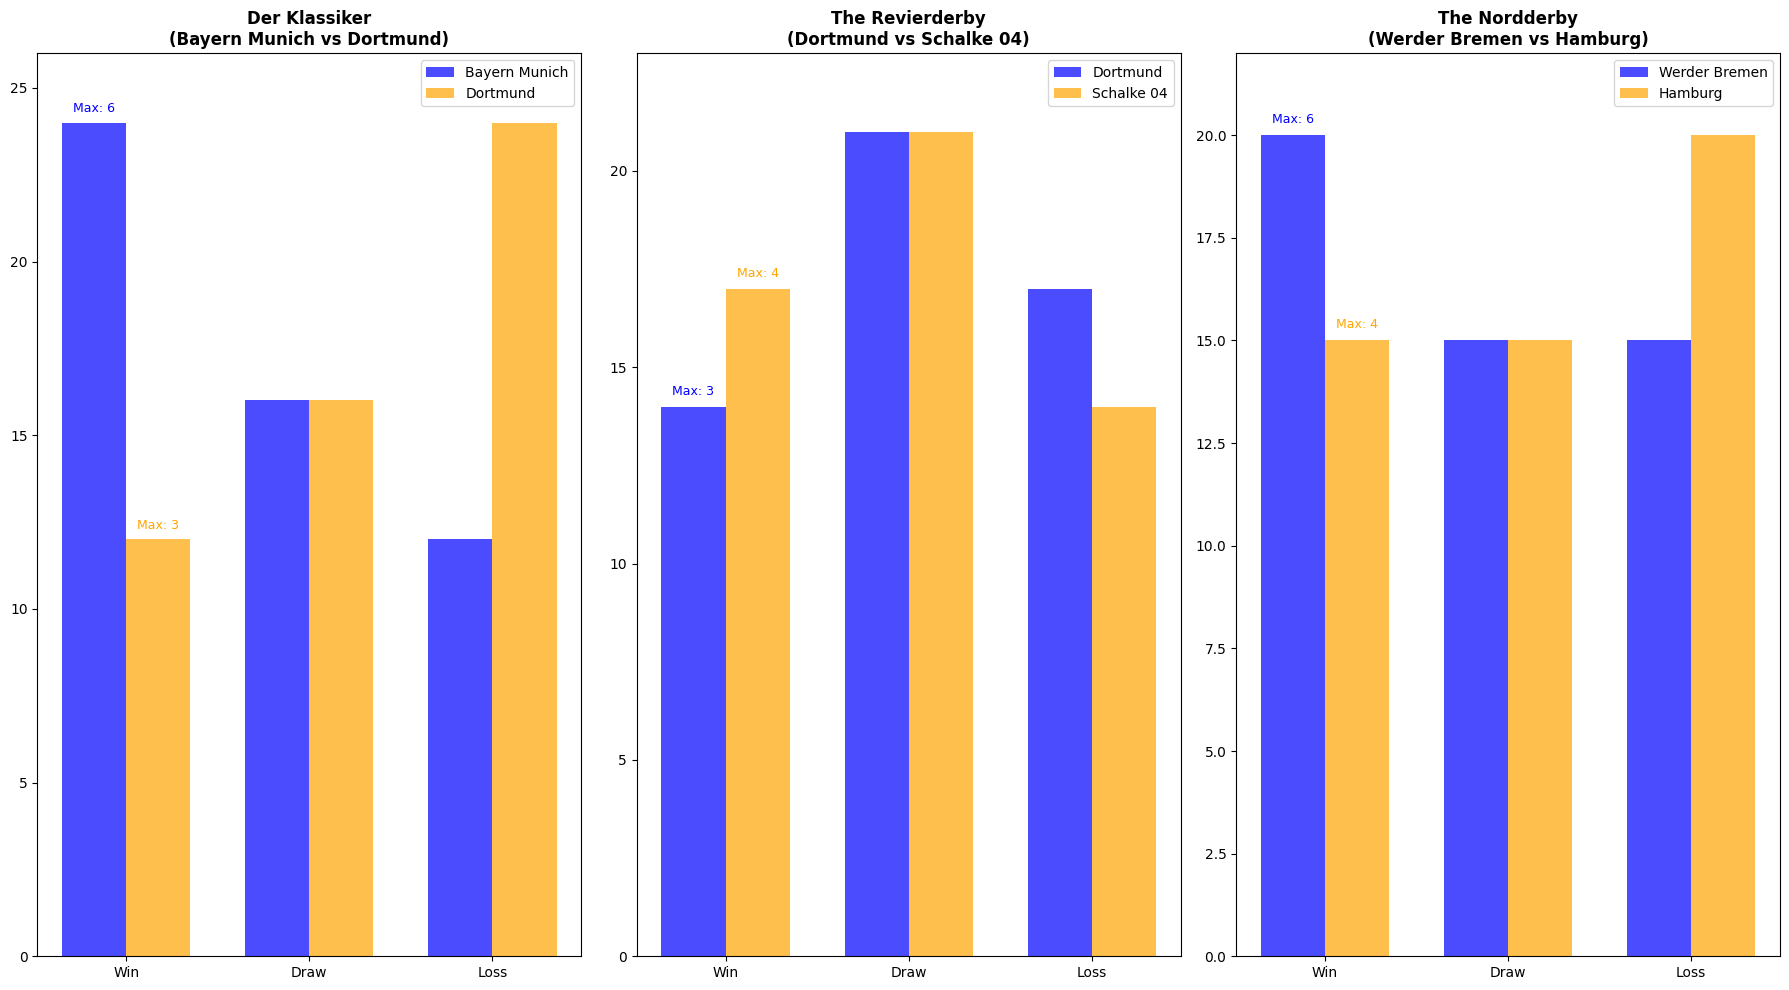

In [21]:
# -- Part 4: Rivalries & Big Match Patterns -- #
# 1. Head-to-Head Matrix for Selected Rivalries
# • Select 5 key rivalries more info click here .
# • Create a facet grid of win/draw/loss bar charts per rivalry.
# • Annotate biggest win margins.

# Only 3 rivalries (I don't watch football :D)
rivalries = [
    {"name": "Der Klassiker", "team1": "Bayern Munich", "team2": "Dortmund"},
    {"name": "The Revierderby", "team1": "Dortmund", "team2": "Schalke 04"},
    {"name": "The Nordderby", "team1": "Werder Bremen", "team2": "Hamburg"}
]

results = ["Win", "Draw", "Loss"]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, rivalry in enumerate(rivalries):
    ax = axes[i]
    team1 = rivalry["team1"]
    team2 = rivalry["team2"]
    rname = rivalry["name"]

    condition = (((bundesliga_df['HOMETEAM'] == team1) & (bundesliga_df['AWAYTEAM'] == team2)) |
                 ((bundesliga_df['HOMETEAM'] == team2) & (bundesliga_df['AWAYTEAM'] == team1)))
    rivalry_df = bundesliga_df[condition]

    counts = {team1: {"Win": 0, "Draw": 0, "Loss": 0},
              team2: {"Win": 0, "Draw": 0, "Loss": 0}}
    max_margin = {team1: 0, team2: 0}

    for idx, row in rivalry_df.iterrows():
        if row['HOMETEAM'] == team1 and row['AWAYTEAM'] == team2:
            if row['FTR'] == "H":
                counts[team1]["Win"] += 1
                counts[team2]["Loss"] += 1
                margin = row['FTHG'] - row['FTAG']
                if margin > max_margin[team1]:
                    max_margin[team1] = margin
            elif row['FTR'] == "A":
                counts[team1]["Loss"] += 1
                counts[team2]["Win"] += 1
                margin = row['FTAG'] - row['FTHG']
                if margin > max_margin[team2]:
                    max_margin[team2] = margin
            elif row['FTR'] == "D":
                counts[team1]["Draw"] += 1
                counts[team2]["Draw"] += 1
        elif row['HOMETEAM'] == team2 and row['AWAYTEAM'] == team1:
            if row['FTR'] == "H":
                counts[team2]["Win"] += 1
                counts[team1]["Loss"] += 1
                margin = row['FTHG'] - row['FTAG']
                if margin > max_margin[team2]:
                    max_margin[team2] = margin
            elif row['FTR'] == "A":
                counts[team2]["Loss"] += 1
                counts[team1]["Win"] += 1
                margin = row['FTAG'] - row['FTHG']
                if margin > max_margin[team1]:
                    max_margin[team1] = margin
            elif row['FTR'] == "D":
                counts[team1]["Draw"] += 1
                counts[team2]["Draw"] += 1

    x = np.arange(len(results))
    width = 0.35

    team1_counts = [counts[team1][res] for res in results]
    team2_counts = [counts[team2][res] for res in results]

    bars1 = ax.bar(x - width/2, team1_counts, width, label=team1, color='blue', alpha=0.7)
    bars2 = ax.bar(x + width/2, team2_counts, width, label=team2, color='orange', alpha=0.7)

    if team1_counts[0] > 0:
        ax.text(x[0] - width/2, team1_counts[0] + 0.3, f"Max: {max_margin[team1]}",
                ha='center', fontsize=9, color='blue')
    if team2_counts[0] > 0:
        ax.text(x[0] + width/2, team2_counts[0] + 0.3, f"Max: {max_margin[team2]}",
                ha='center', fontsize=9, color='orange')

    ax.set_xticks(x)
    ax.set_xticklabels(results, fontsize=10)
    y_max = max(max(team1_counts), max(team2_counts)) + 2
    ax.set_ylim(0, y_max)
    ax.set_title(f"{rname}\n({team1} vs {team2})", fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

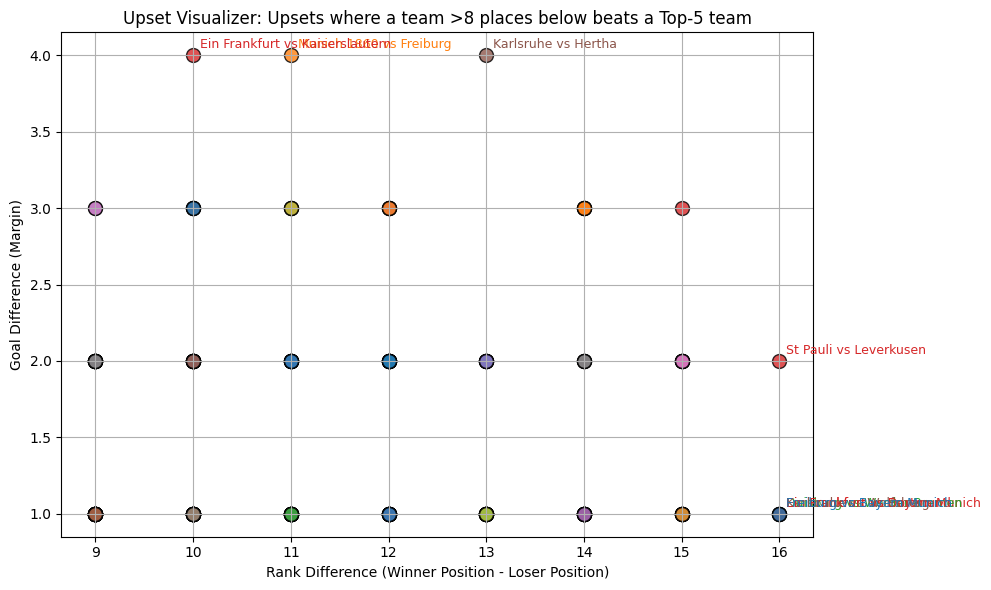

In [29]:
# 2. Upset Visualizer
# • Define “upset” as a team >8 places below beating a top-5 team.
# • Scatterplot of upsets: x-axis = rank difference, y-axis = goal difference.
# • Encode team colors; highlight and label famous upsets

# Filter out matches with a decisive result
matches = bundesliga_df[bundesliga_df['FTR'].isin(['H', 'A'])].copy()

def get_winner(row):
    return row['HOMETEAM'] if row['FTR'] == 'H' else row['AWAYTEAM']

def get_loser(row):
    return row['AWAYTEAM'] if row['FTR'] == 'H' else row['HOMETEAM']

def get_margin(row):
    if row['FTR'] == 'H':
        return row['FTHG'] - row['FTAG']
    else:
        return row['FTAG'] - row['FTHG']

matches['Winner'] = matches.apply(get_winner, axis=1)
matches['Loser'] = matches.apply(get_loser, axis=1)
matches['Margin'] = matches.apply(get_margin, axis=1)

winner_standings = bundesliga2_df[['SEASON', 'TEAM', 'POSITION']].rename(
    columns={'TEAM': 'Winner', 'POSITION': 'Winner_Position'})
loser_standings = bundesliga2_df[['SEASON', 'TEAM', 'POSITION']].rename(
    columns={'TEAM': 'Loser', 'POSITION': 'Loser_Position'})

matches = pd.merge(matches, winner_standings, on=['SEASON', 'Winner'], how='left')
matches = pd.merge(matches, loser_standings, on=['SEASON', 'Loser'], how='left')

# A match is an upset if:
# 1. The losing team finished in the top 5 (Loser_Position <= 5)
# 2. The winning team finished >8 positions below the losing team
upsets = matches[(matches['Loser_Position'] <= 5) &
                 ((matches['Winner_Position'] - matches['Loser_Position']) > 8)].copy()

upsets['Rank_Diff'] = upsets['Winner_Position'] - upsets['Loser_Position']

plt.figure(figsize=(10, 6))

unique_winners = upsets['Winner'].unique()
cmap = plt.get_cmap('tab10', len(unique_winners))
colors = cmap(np.linspace(0, 1, len(unique_winners)))
color_dict = {team: col for team, col in zip(unique_winners, colors)}

for idx, row in upsets.iterrows():
    plt.scatter(row['Rank_Diff'], row['Margin'], color=color_dict[row['Winner']],
                s=100, edgecolor='k', alpha=0.8)

    if row['Rank_Diff'] > 15 or row['Margin'] >= 4:
        label = f"{row['Winner']} vs {row['Loser']}"
        plt.annotate(label, (row['Rank_Diff'], row['Margin']),
                     textcoords="offset points", xytext=(5, 5), fontsize=9,
                     color=color_dict[row['Winner']])

plt.xlabel("Rank Difference (Winner Position - Loser Position)")
plt.ylabel("Goal Difference (Margin)")
plt.title("Upset Visualizer: Upsets where a team >8 places below beats a Top-5 team")
plt.grid(True)
plt.tight_layout()
plt.show()

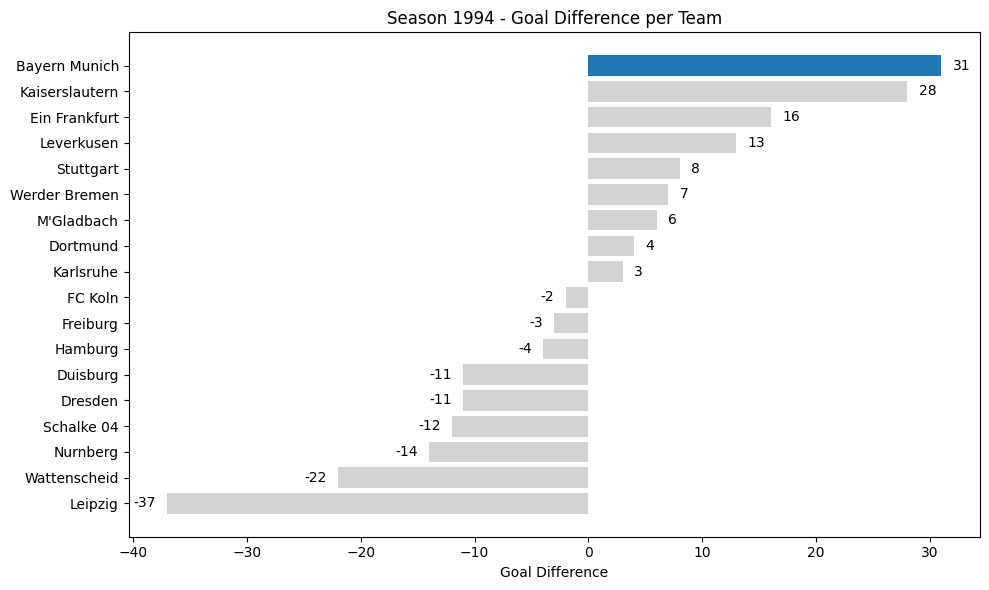

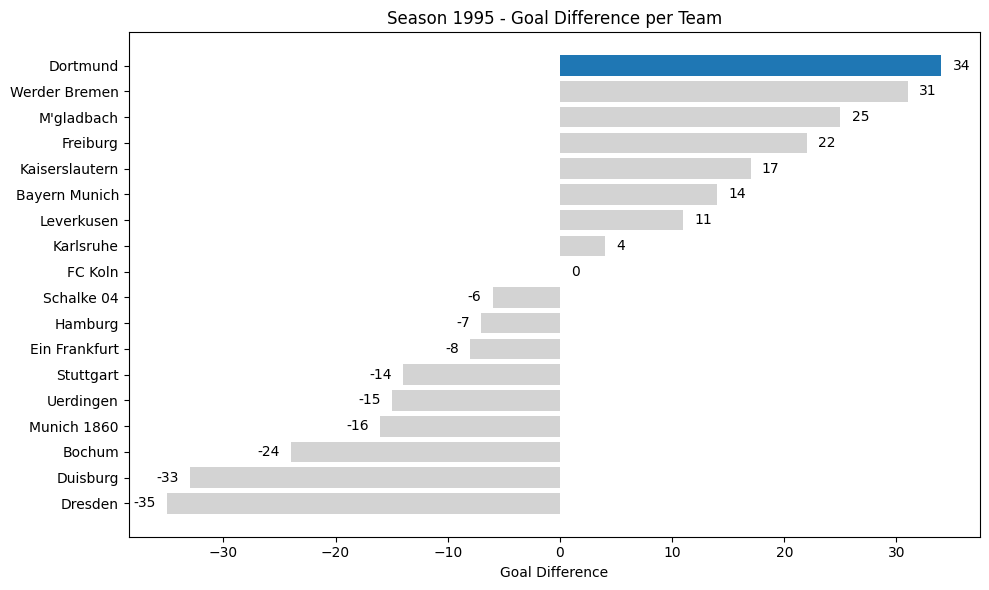

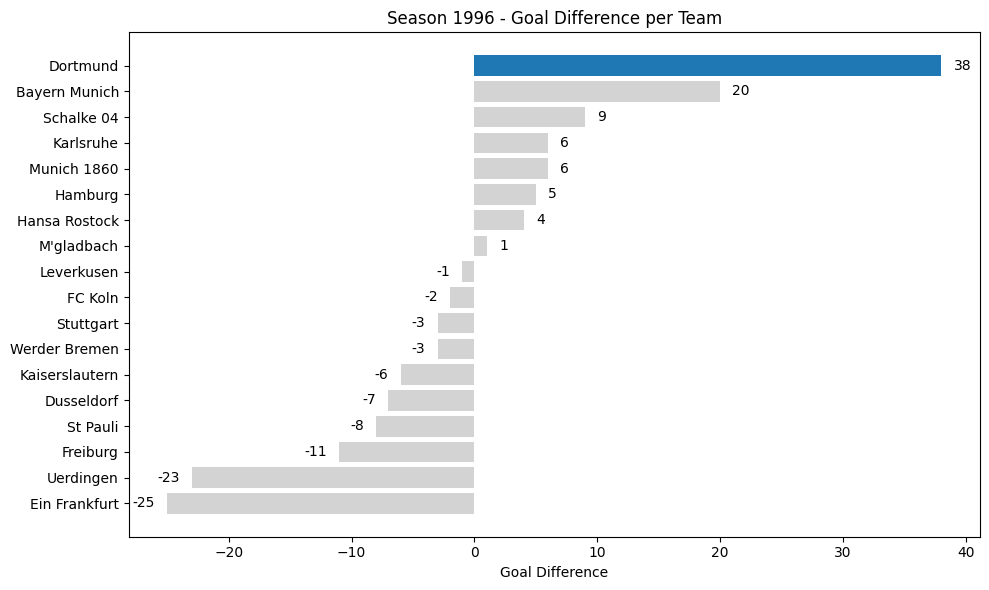

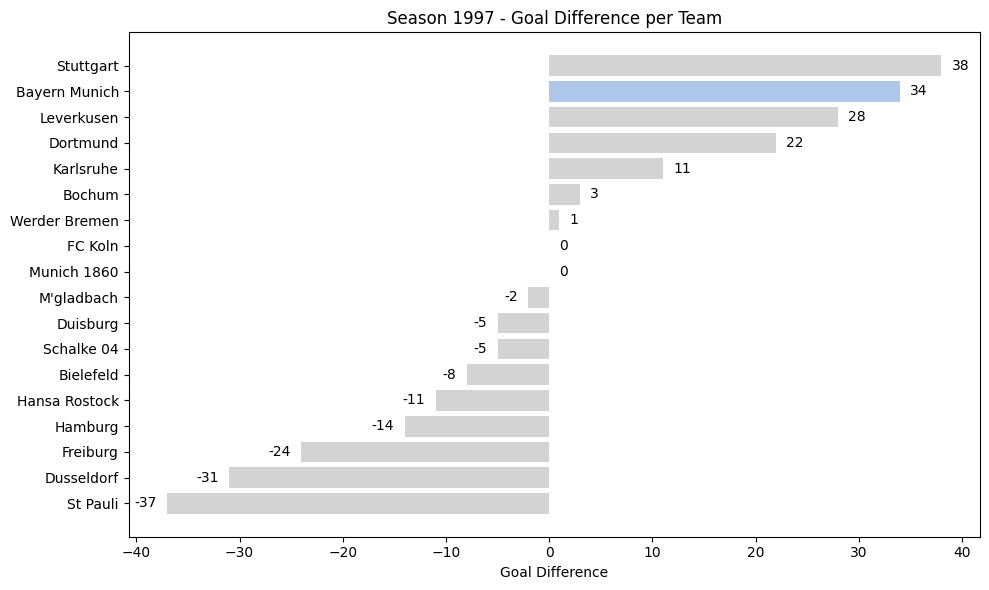

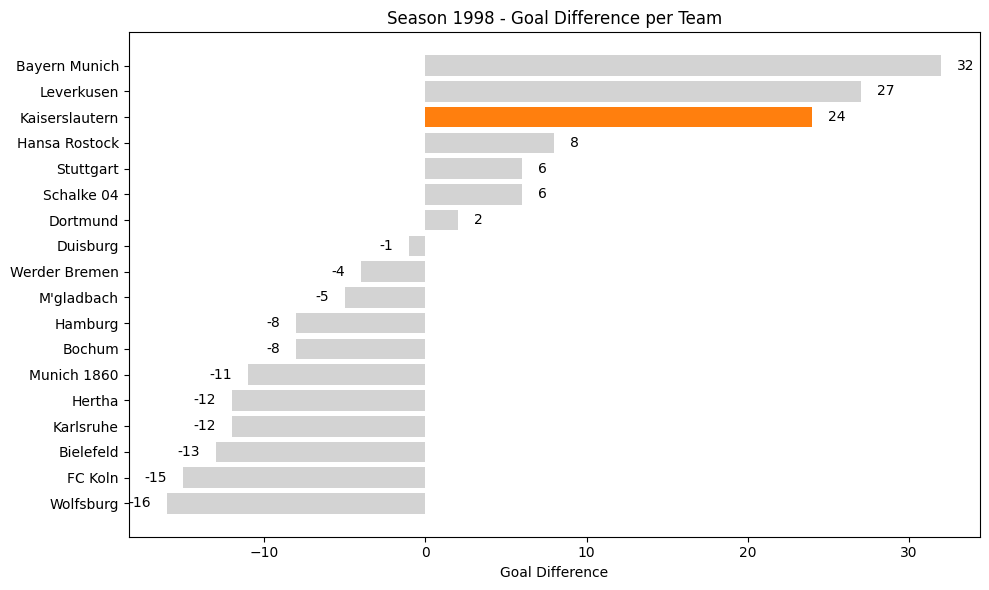

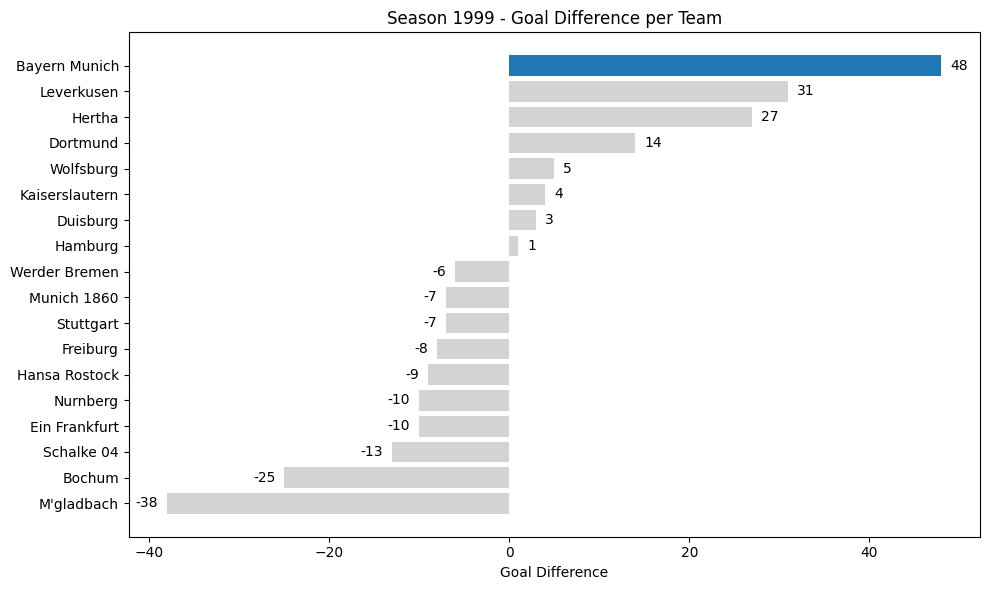

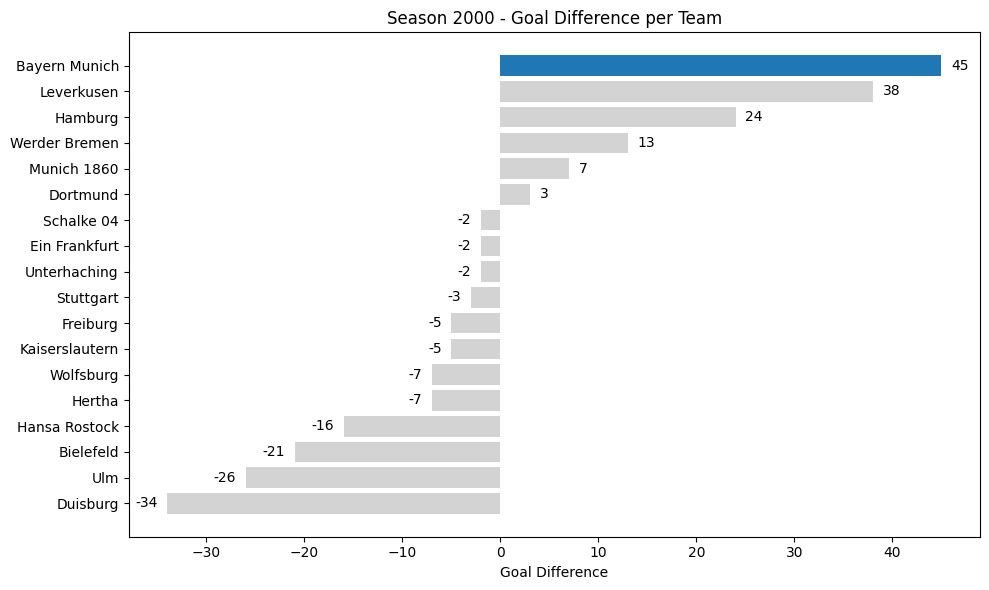

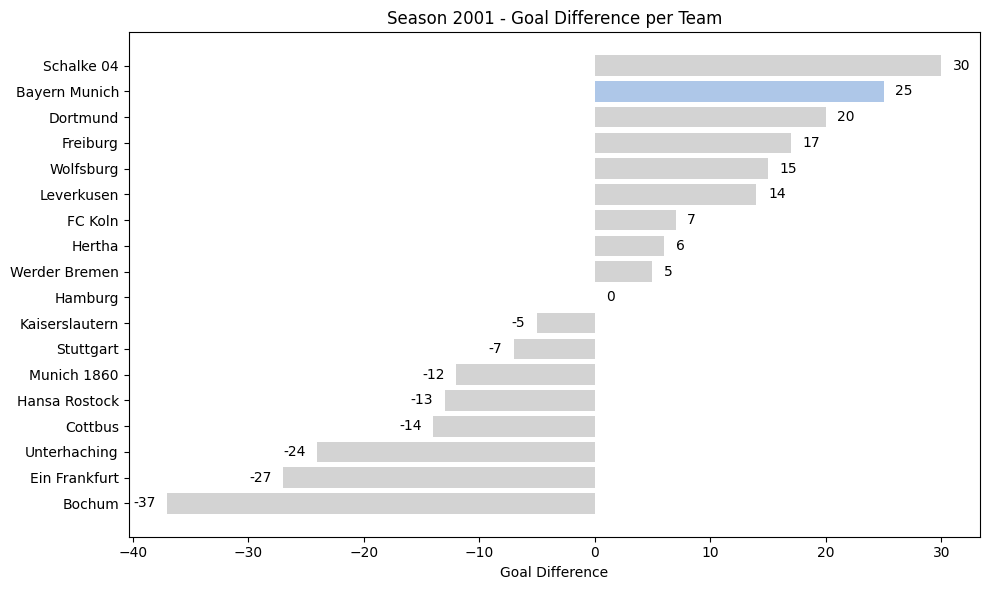

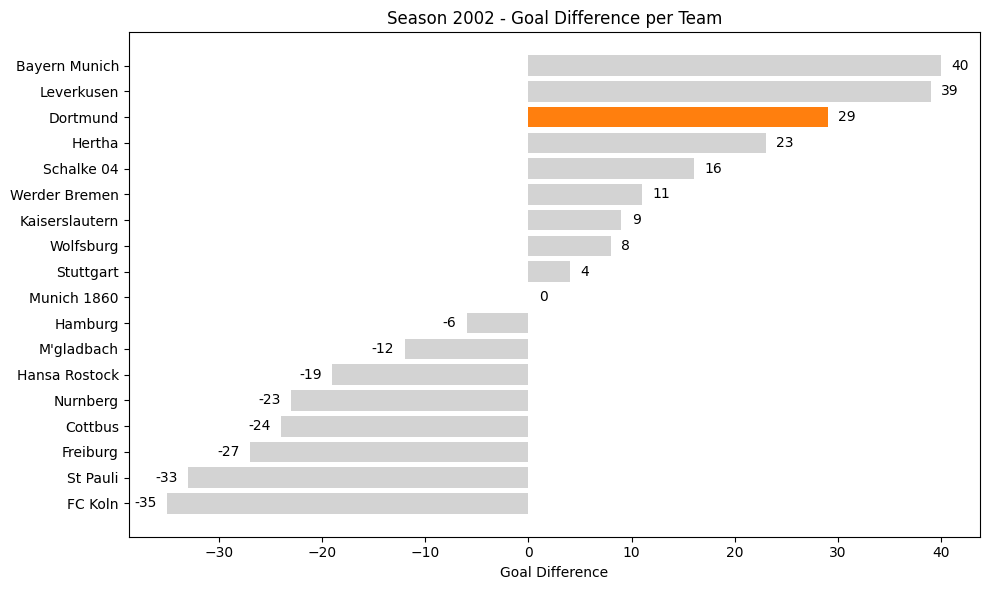

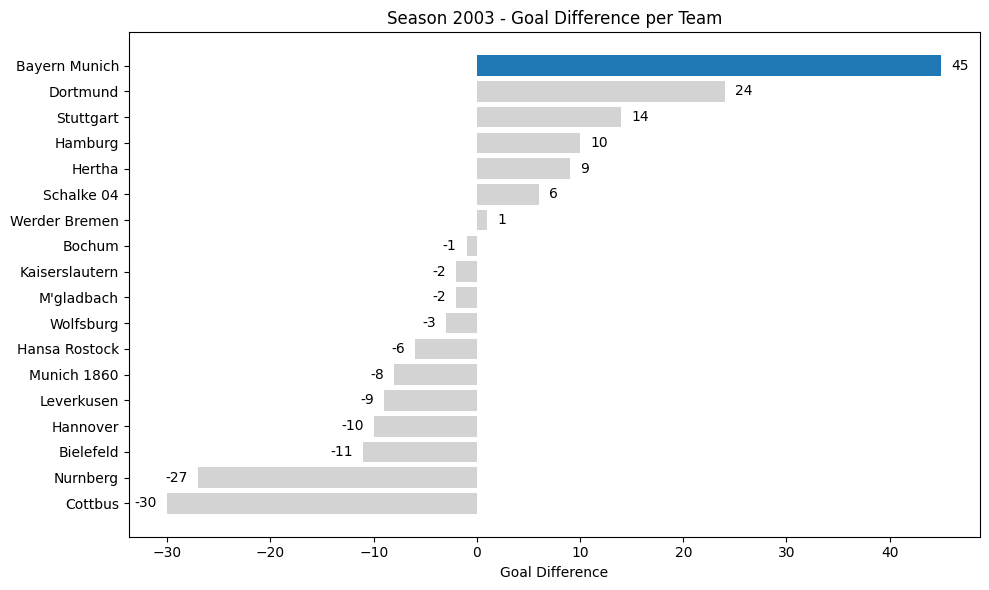

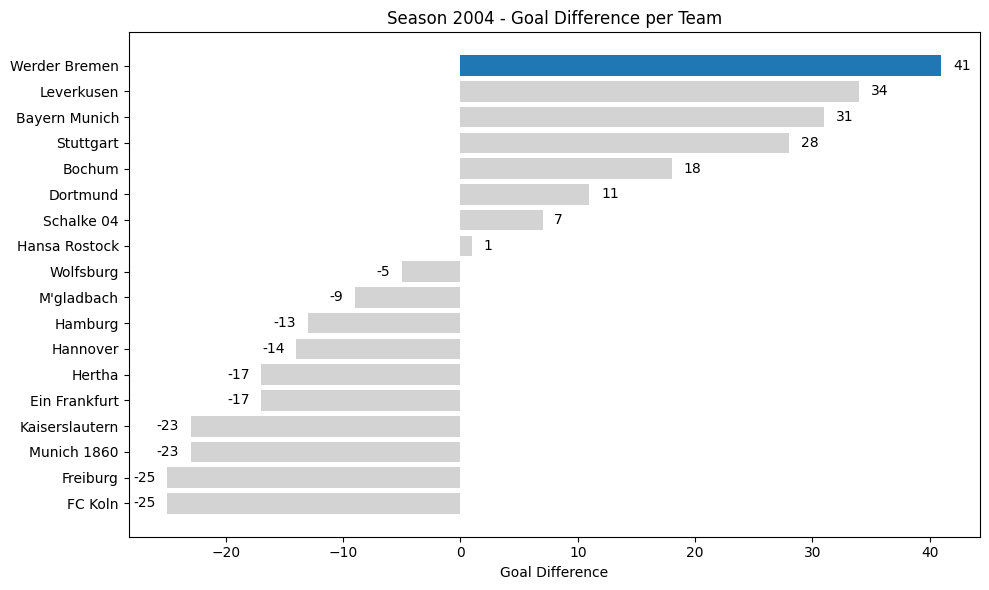

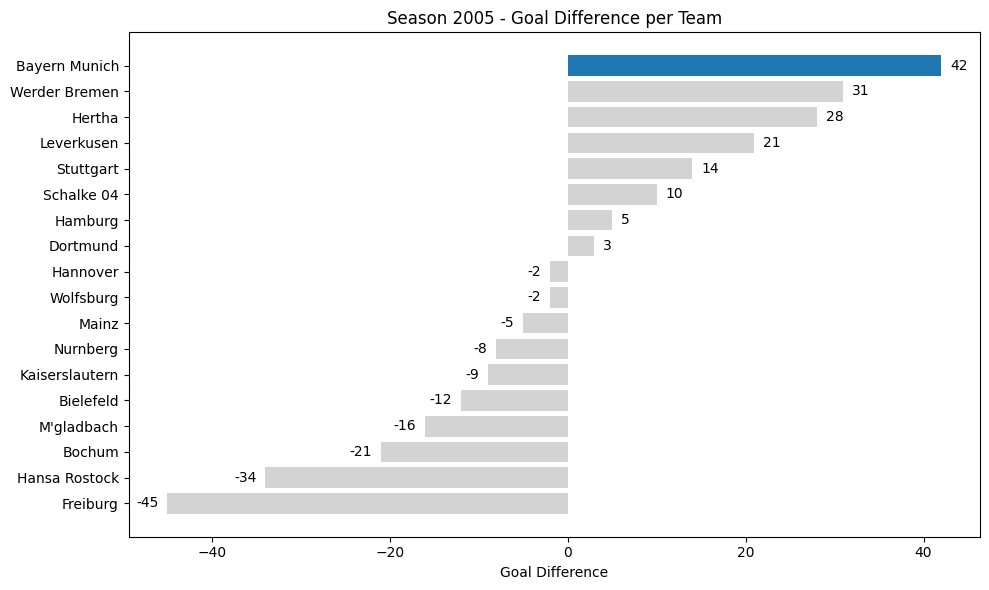

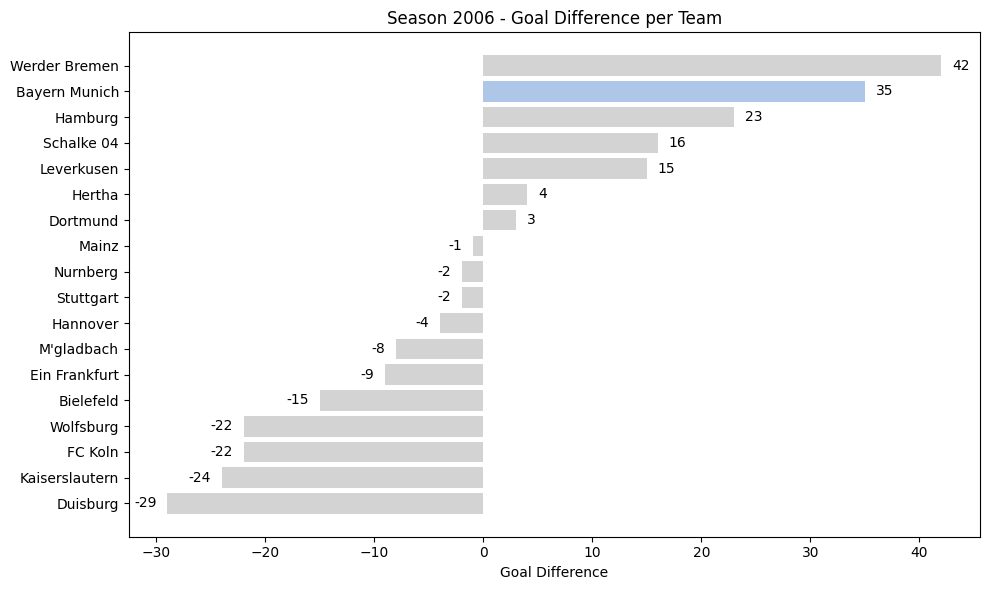

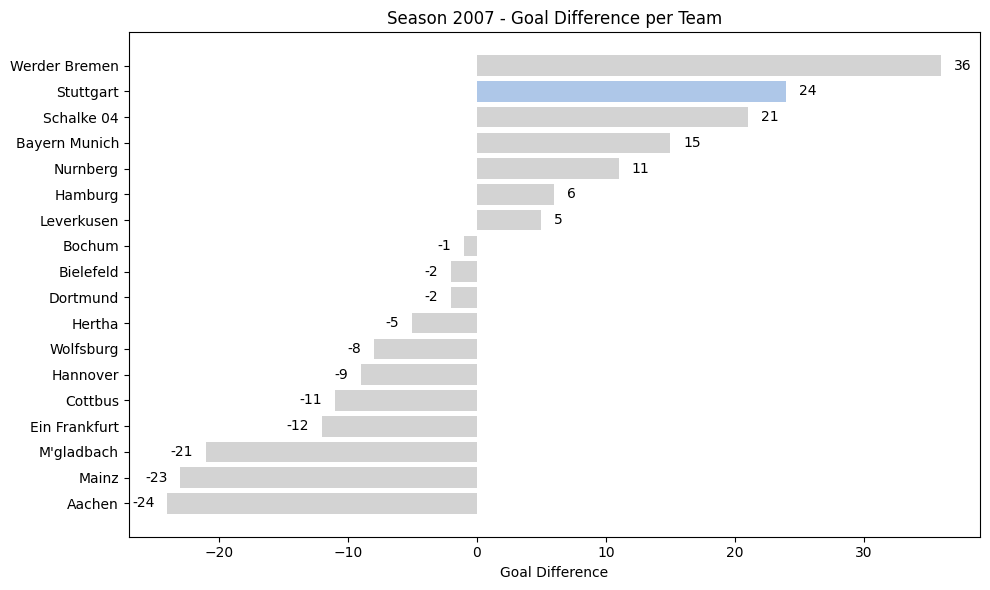

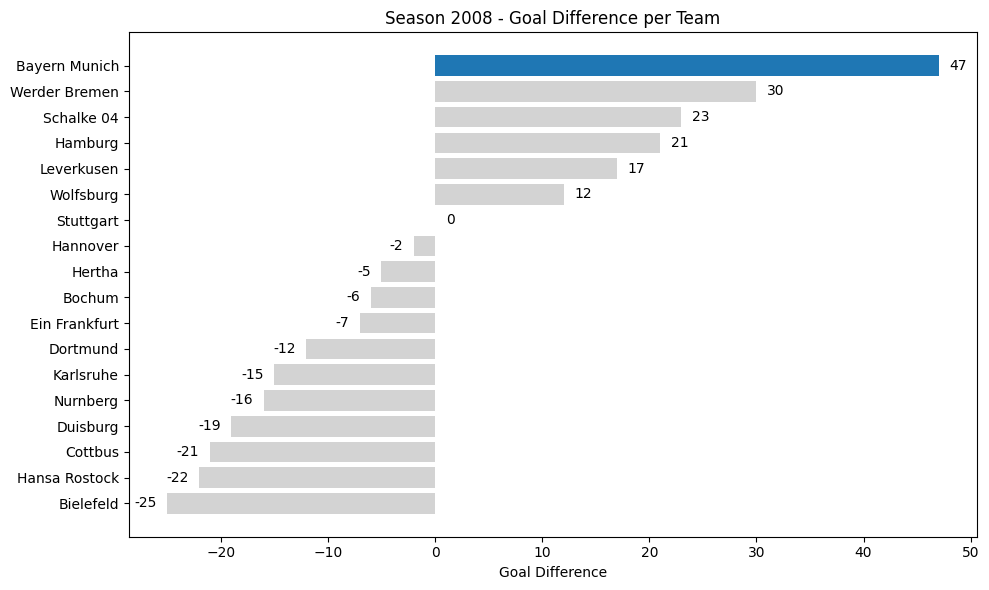

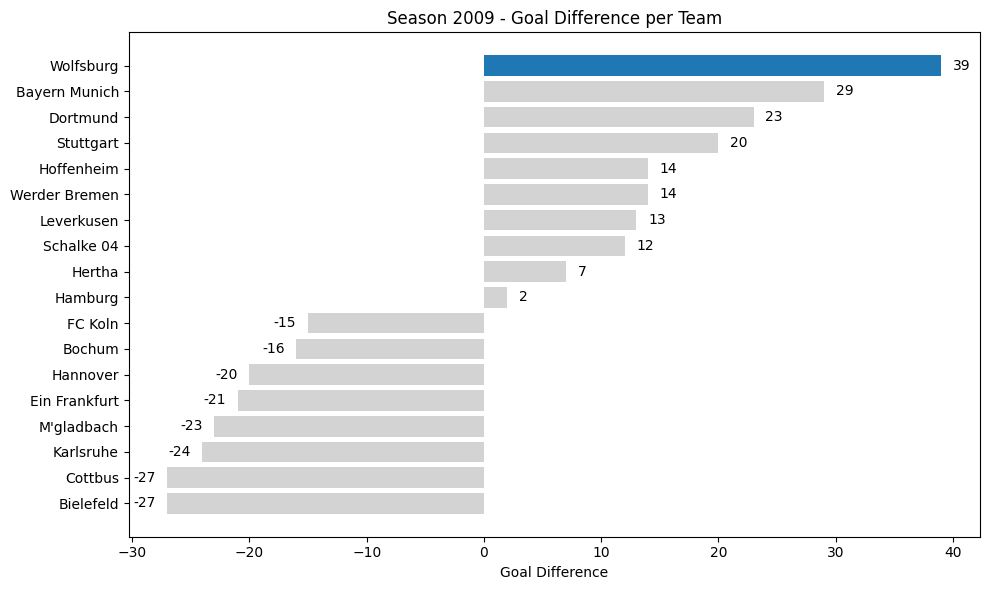

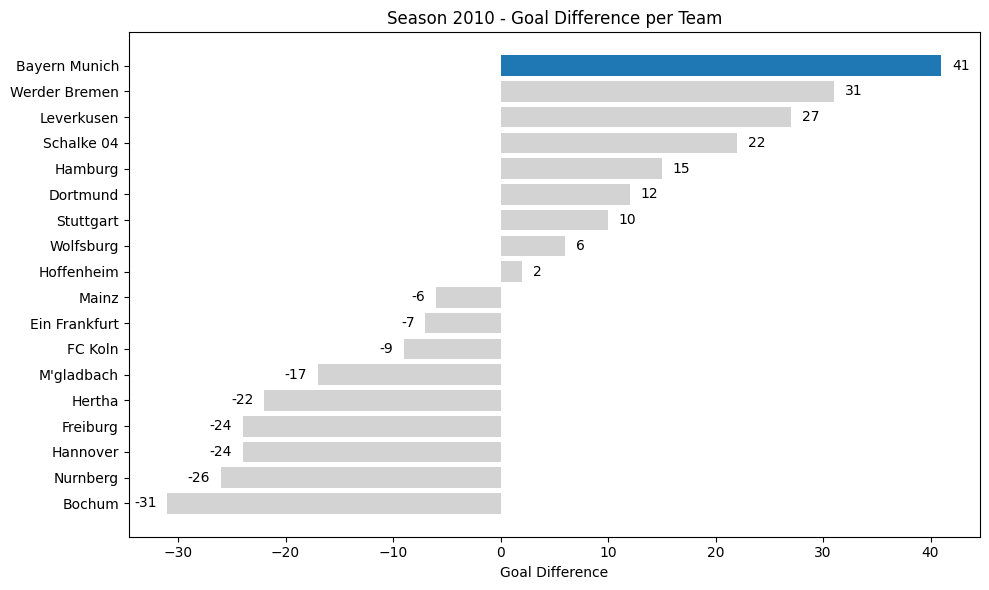

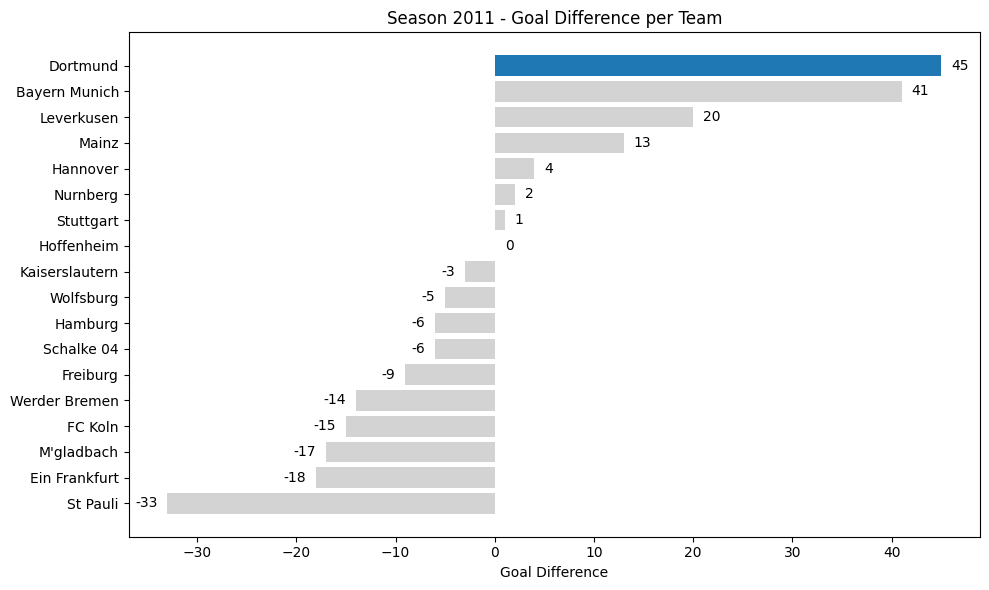

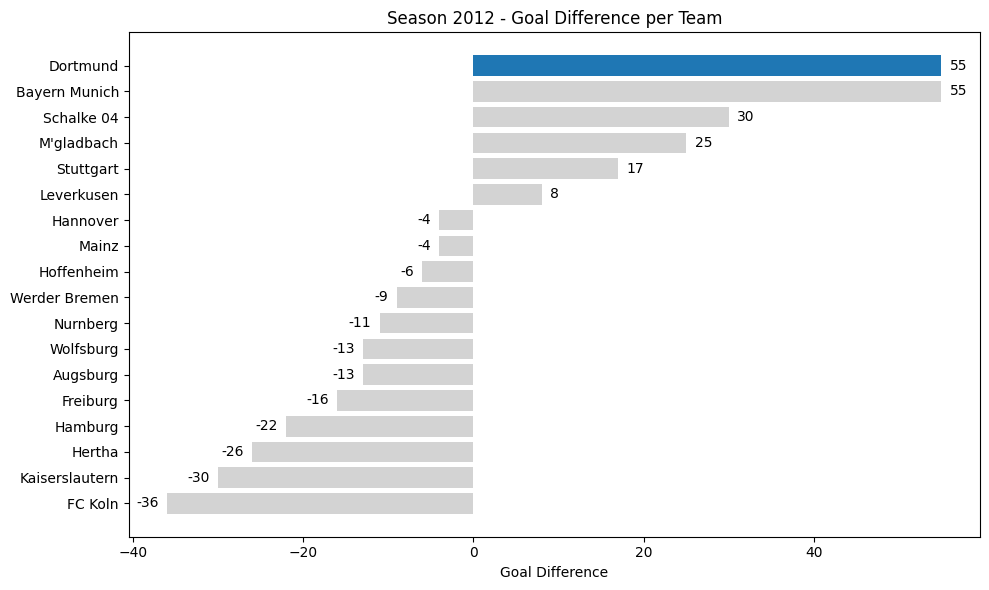

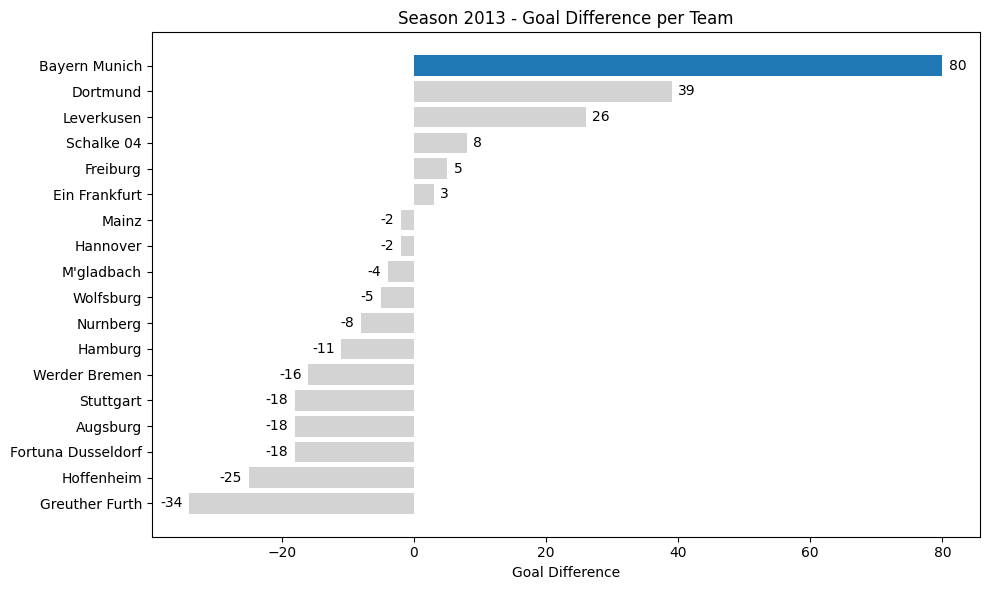

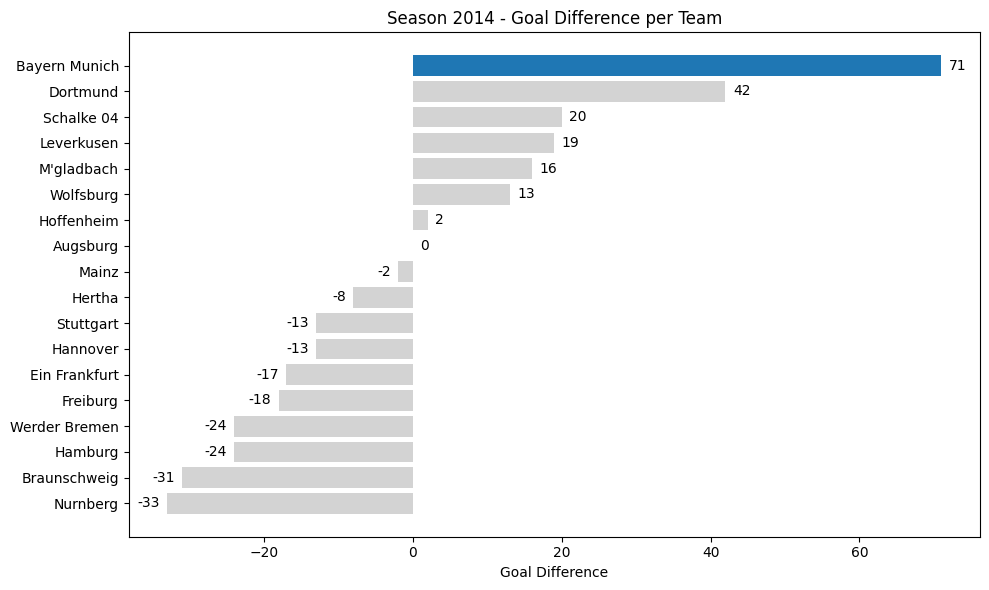

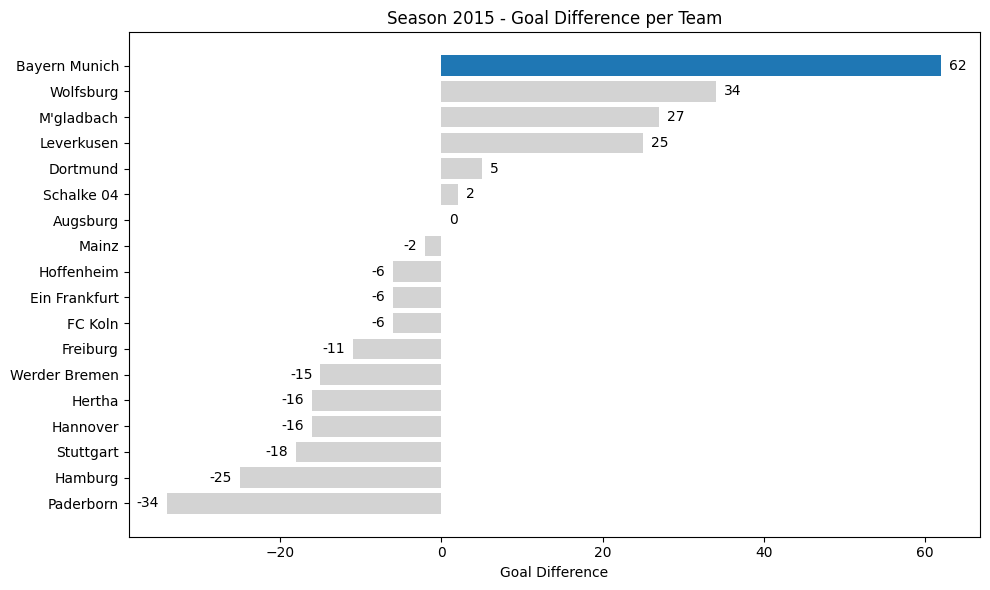

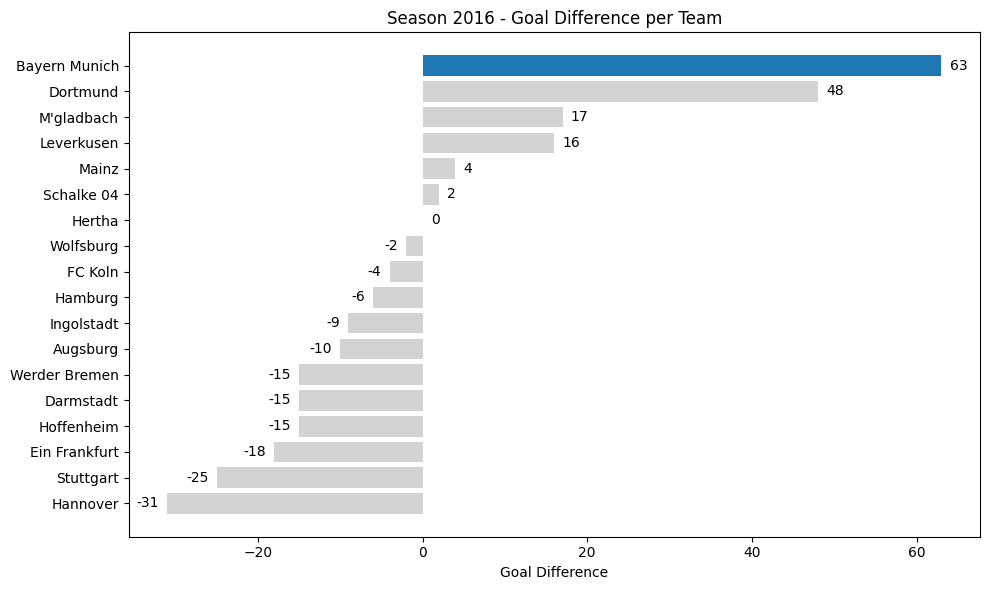

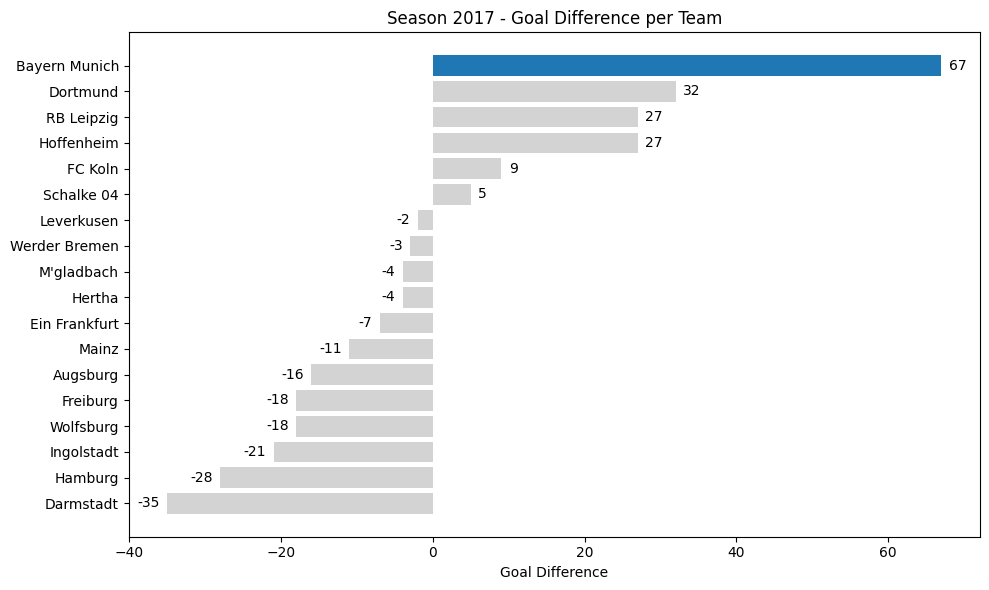

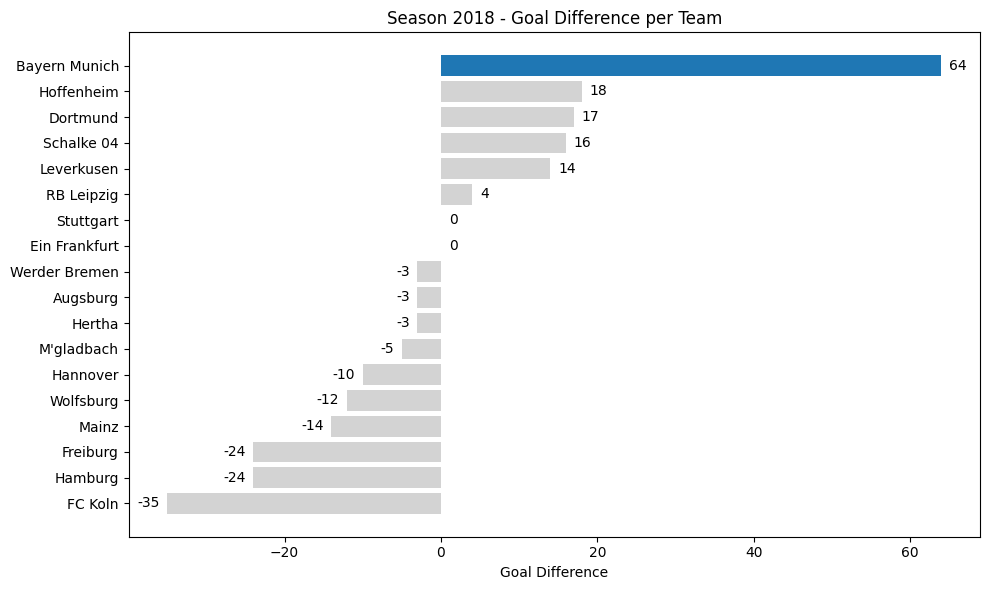

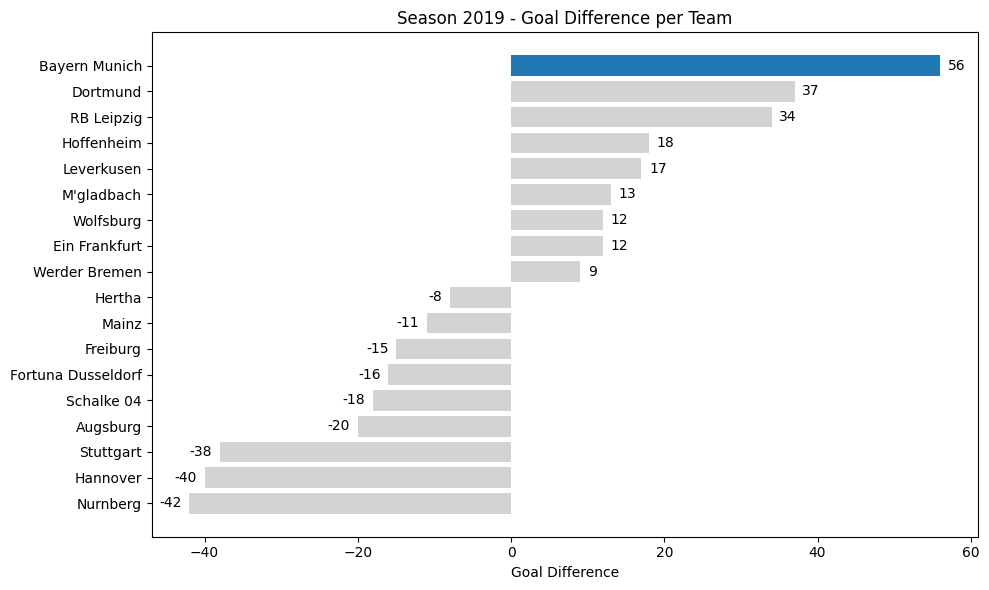

In [31]:
# -- Part 5: Overall performance -- #
# • Define unique color for each team per season. For each season create horizontal bar plot using total
# number of points. Highlighting the winner with the unique color that you assigned to it. Save all
# graphs in pdf. (R)
# • Redo the same task in python. But instead of total points use goal difference. Use same logic for colors
# as in first part. (Python)

seasons = sorted(bundesliga2_df['SEASON'].unique(), key=lambda x: int(x))

for season in seasons:
    season_df = bundesliga2_df[bundesliga2_df['SEASON'] == season].copy()
    season_df = season_df.sort_values(by='DIFF', ascending=False)

    teams = season_df['TEAM'].tolist()
    num_teams = len(teams)
    cmap = plt.get_cmap('tab20', num_teams)
    color_dict = {team: cmap(i) for i, team in enumerate(teams)}

    bar_colors = [color_dict[row['TEAM']] if row['POSITION'] == 1 else 'lightgray'
                  for idx, row in season_df.iterrows()]

    plt.figure(figsize=(10, 6))
    plt.barh(season_df['TEAM'], season_df['DIFF'], color=bar_colors)

    for index, row in season_df.iterrows():
        plt.text(row['DIFF'] + (1 if row['DIFF'] >= 0 else -1),
                 row['TEAM'],
                 str(row['DIFF']),
                 va='center',
                 ha='left' if row['DIFF'] >= 0 else 'right',
                 fontsize=10)

    plt.xlabel("Goal Difference")
    plt.title(f"Season {season} - Goal Difference per Team")
    plt.gca().invert_yaxis()  # so the top team is at the top
    plt.tight_layout()
    plt.show()

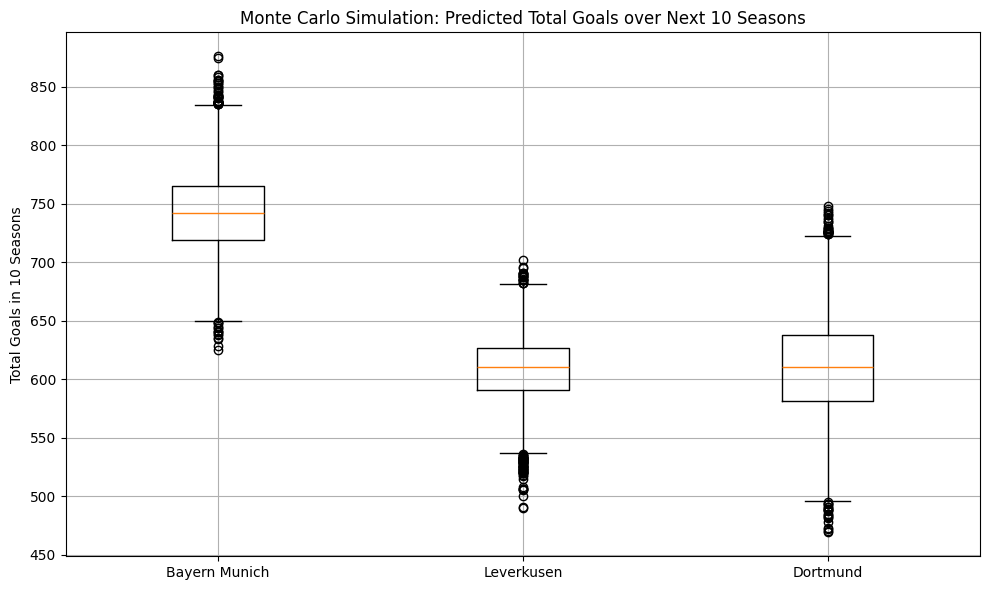

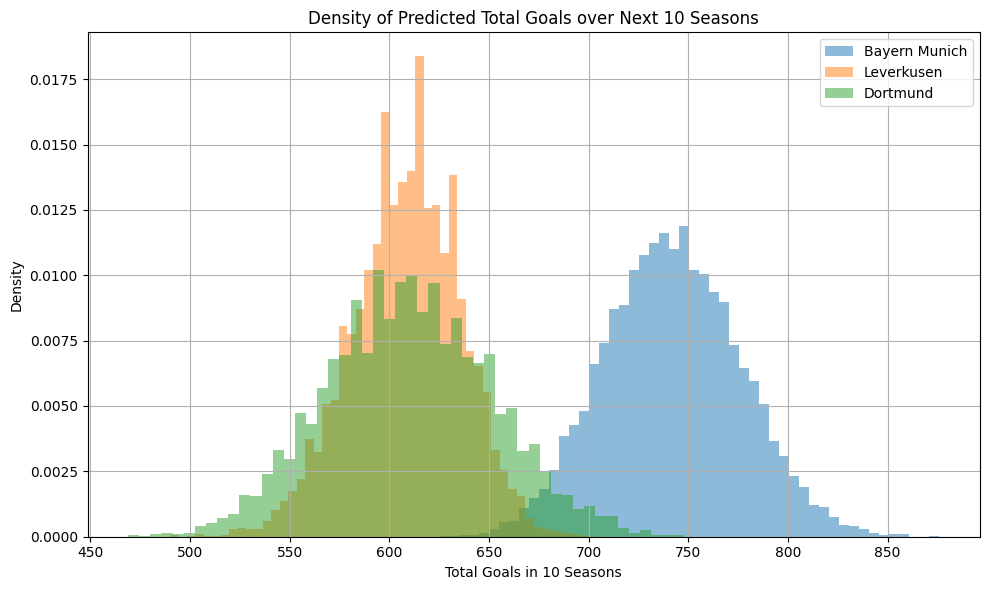

In [35]:
# -- Part 6. Monte Carlo simulation. -- #
# Use Monte Carlo simulation to predict how many goals will Bayern Munchen score for next 10 seasons. Repeat the same for Bayer Leverkusen and Borusia Dortmund. Compare results using appropriate visualization technique.

# Simulation parameters
n_simulations = 10000
n_seasons = 10

teams_to_simulate = ["Bayern Munich", "Leverkusen", "Dortmund"]

simulation_results = {}

for team in teams_to_simulate:
    team_data = bundesliga2_df[bundesliga2_df['TEAM'].str.contains(team, case=False)]
    historical_GF = team_data['GF'].values
    if len(historical_GF) == 0:
        print(f"No historical data found for {team}")
        continue

    total_goals = [np.sum(np.random.choice(historical_GF, n_seasons, replace=True))
                   for _ in range(n_simulations)]
    simulation_results[team] = total_goals

# -----------------------
# Boxplots
# -----------------------
plt.figure(figsize=(10, 6))
data_to_plot = [simulation_results[team] for team in teams_to_simulate if team in simulation_results]
plt.boxplot(data_to_plot, tick_labels=[team for team in teams_to_simulate if team in simulation_results])
plt.ylabel("Total Goals in 10 Seasons")
plt.title("Monte Carlo Simulation: Predicted Total Goals over Next 10 Seasons")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Density Plots
# ---------------------------
plt.figure(figsize=(10, 6))
for team in teams_to_simulate:
    if team in simulation_results:
        plt.hist(simulation_results[team], bins=50, alpha=0.5, density=True, label=team)
plt.xlabel("Total Goals in 10 Seasons")
plt.ylabel("Density")
plt.title("Density of Predicted Total Goals over Next 10 Seasons")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()